## Goal: try to estimate functional uncertainty of DASM selection factor using mc dropout.
This notebook explores the distributions of different mc dropout aggregations and compares them to functional measurements by Koenig.


1. We ran MC dropout in order to get uncertainty estimates, and created different statistics on the distribution for every combination of position and amino acid (credible interval - CI, normalized CI, coefficient of variation, standard deviation).
2. We wanted to see if one of these statistics was better as an uncertainty estimate than others. To do this, we looked at the correlation between the uncertainty measure and the mean prediction value, and found that all of them were correlated - not necessarily a good sign when looking for an uncertainty estimate  (cell 19).
3. For testing on functional data, we used the Koenig dataset to compare the mean selection factor and the expression value. We looked for pearson correlation and sign aggreement between the two as a measure of a good prediction, sign agreement seems to be better as we understand the meaning of that best. We tested whether the sign aggreement was different between the quantiles of the uncertainty measure, and also between quantiles of mean prediciton value (cell 35). We found that in the extreme selection factors (negative) the uncertainty measure was separating between the better and worse predictions as we would expect, but for mean prediction values closer to 0 it is not doing so. This was true for the different measurements we tried.


Conclusion: 
the different mc dropout measures we tried were not good uncertainty predictions of the functional measurements.


In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from scipy import stats
import os
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.patches import Patch
import matplotlib.ticker as ticker
import tqdm


from netam.common import heavy_chain_shim
from netam.framework import load_crepe
from netam.sequences import translate_sequence, AA_STR_SORTED
from dnsmex.dasm_viz import dms_style_heatmap
from dnsmex.local import localify
from dnsmex.koenig_helper import KoenigDataset, plot_variant_comparison
from netam.sequences import (AA_STR_SORTED)
from dnsmex.dasm_mc_dropout import *



figures_dir = localify("FIGURES_DIR")
os.makedirs("_output", exist_ok=True)


In [2]:
import warnings
import numpy as np

# Filter out the specific NumPy deprecation warning about __array_wrap__
warnings.filterwarnings("ignore", category=DeprecationWarning, 
                       message="__array_wrap__ must accept context and return_scalar")


In [3]:
heavy_wt = "EVQLVESGGGLVQPGGSLRLSCAASGFTISDYWIHWVRQAPGKGLEWVAGITPAGGYTYYADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYYCARFVFFLPYAMDYWGQGTLVTVSS"

In [4]:
def assign_wt(df, wt_seq, value):
    for idx, aa in enumerate(wt_seq):
        df.loc[aa, idx+1] = value

def df_of_arr(arr):
    return pd.DataFrame(arr, columns=range(1, arr.shape[1] + 1), index=list(AA_STR_SORTED))

In [5]:
# Load DASM model
crepe = load_crepe(localify("DASM_TRAINED_MODELS_DIR/dasm_4m-v1jaffeCC+v1tangCC-joint"))
#crepe.model.train()
crepe = heavy_chain_shim(crepe)
[dasm_heavy] = crepe([heavy_wt])
log_dasm_heavy = (np.log(dasm_heavy).T)
log_dasm_heavy_df = df_of_arr(log_dasm_heavy)
assign_wt(log_dasm_heavy_df, heavy_wt, np.nan)

In [6]:
log_dasm_heavy

tensor([[-0.7227, -0.6347, -0.4639,  ..., -1.7577, -0.3251,  0.7484],
        [ 0.2837,  0.0109, -2.4311,  ..., -2.0141, -4.4042, -3.1741],
        [-0.5426, -0.6284, -0.8591,  ..., -4.1694,  0.8741,  0.3483],
        ...,
        [-1.9546,     nan,  0.8395,  ...,     nan, -0.0692,  0.5724],
        [-2.4160, -1.8430, -2.3934,  ..., -3.5998, -2.4099, -0.1343],
        [-2.5593, -0.7266,  0.1817,  ..., -4.7174, -0.9831, -1.0503]])

In [7]:
def zero_centered_cb_min_center_max(df):
    data_min = df.min().min()
    data_max = df.max().max()
    assert data_min < 0 and data_max > 0
    return data_min, 0, data_max

def make_heatmap(df, ax, colorbar_label):
    _ = dms_style_heatmap(
        df, 
        ax=ax, 
        cb_min_center_max=zero_centered_cb_min_center_max(df), 
        plot_aa_order=list("YWFLIVAMKRHDESTNQPGC"),
        colorbar_label=colorbar_label)

EVQLVESGGGLVQPGGSLRLSCAASGFTISDYWIHWVRQAPGKGLEWVAGITPAGGYTYYADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYYCARFVFFLPYAMDYWGQGTLVTVSS


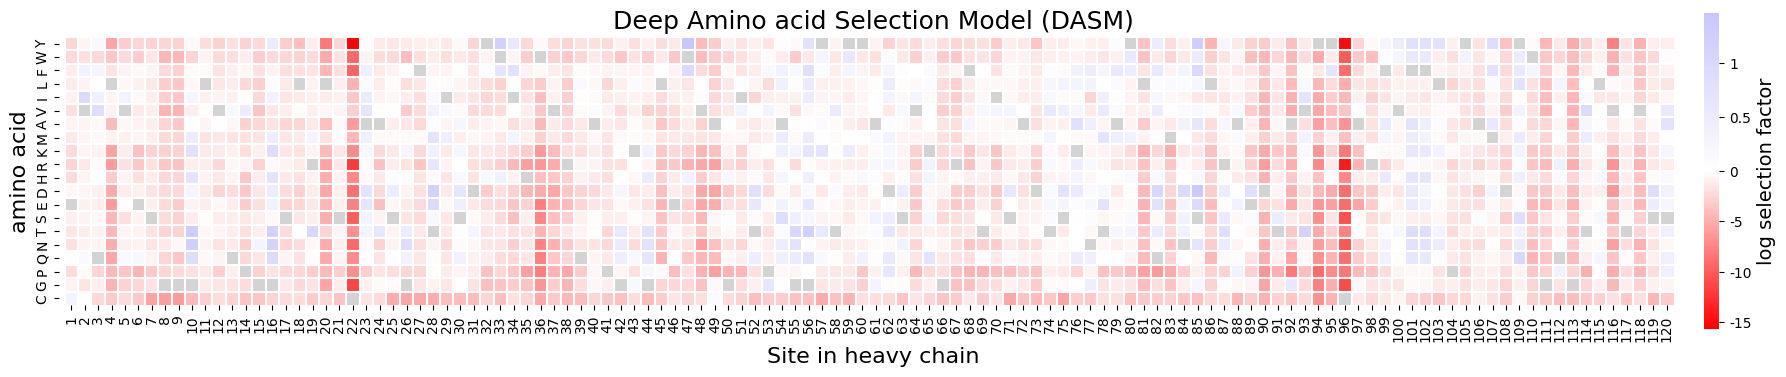

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(18, 4))

print(heavy_wt)

make_heatmap(log_dasm_heavy_df, ax, "log selection factor")
ax.set_title('Deep Amino acid Selection Model (DASM)', fontsize=18)
ax.set_xlabel('Site in heavy chain', fontsize=16)
ax.set_ylabel('amino acid', fontsize=16)
plt.tight_layout()

# calculate different confidence measures

In [9]:

stats_df = compare_models_w_mc_dropout("DASM_TRAINED_MODELS_DIR/dasm_4m-v1jaffeCC+v1tangCC-joint", "DASM_TRAINED_MODELS_DIR/dasm_4m-v1jaffeCC+v1tangCC-joint", [heavy_wt], mc_dropout_iterations=100, dropout_prob=0.3, device='cuda')


100%|██████████| 1/1 [00:05<00:00,  5.38s/it]


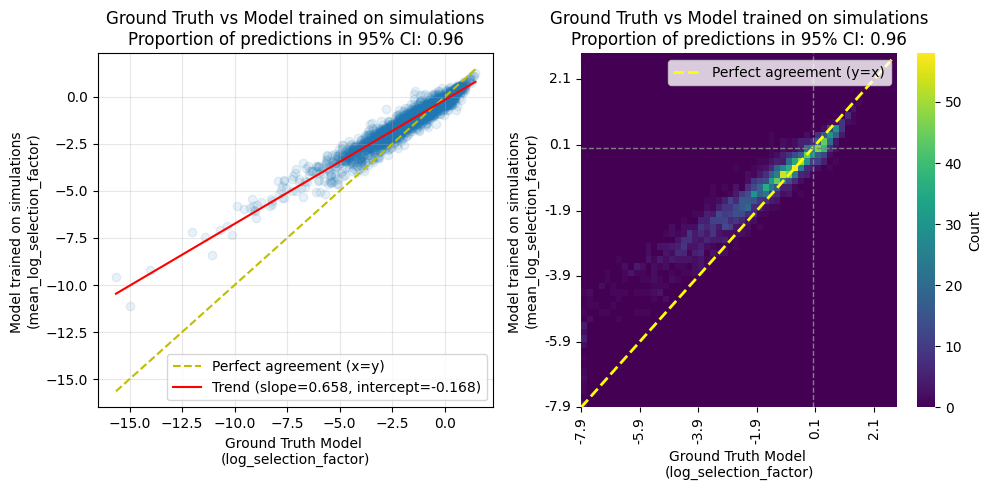

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
axes = ax.flatten()
fig = plot_compare_models_w_mc_dropout_prediction_scatter(stats_df, axes[0])
fig = plot_compare_models_w_mc_dropout_prediction_seaborn_heatmap(stats_df, axes[1])


In [11]:
def run_mc_dropout(heavy_wt=heavy_wt, num_predictions=500):
    # Load DASM model and put in training mode
    crepe = load_crepe(localify("DASM_TRAINED_MODELS_DIR/dasm_4m-v1jaffeCC+v1tangCC-joint"))
    crepe.model.train()
    crepe = heavy_chain_shim(crepe)

    # Initialize a list to store all predictions
    dasm_heavy_predictions = []

    # Run the model multiple times and save predictions
    for i in tqdm.tqdm(range(num_predictions)):
        # Get raw predictions
        [dasm_heavy] = crepe([heavy_wt])
        
        # Save raw predictions (before log)
        raw_dasm_heavy_df = df_of_arr(dasm_heavy.T)
        assign_wt(raw_dasm_heavy_df, heavy_wt, np.nan)
        raw_dasm_heavy_df_long = raw_dasm_heavy_df.stack().reset_index()
        raw_dasm_heavy_df_long.columns = ['AminoAcid', 'Position', 'selection_factor']
        
        # Save log-transformed predictions
        log_dasm_heavy = np.log(dasm_heavy).T
        log_dasm_heavy_df = df_of_arr(log_dasm_heavy)
        assign_wt(log_dasm_heavy_df, heavy_wt, np.nan)
        log_dasm_heavy_df_long = log_dasm_heavy_df.stack().reset_index()
        log_dasm_heavy_df_long.columns = ['AminoAcid', 'Position', 'log_selection_factor']
        
        # Merge raw and log predictions
        combined_df = pd.merge(
            raw_dasm_heavy_df_long, 
            log_dasm_heavy_df_long,
            on=['AminoAcid', 'Position']
        )
        
        # Add sample identifier
        combined_df['Sample'] = i
        
        dasm_heavy_predictions.append(combined_df)

    # Combine all samples
    all_data = pd.concat(dasm_heavy_predictions, ignore_index=True)
    return all_data

if not os.path.exists(localify("DATA_DIR/uncertainty/functional_uncertainty/mc_dropout_data_koenig.csv")):
    all_data = run_mc_dropout()
    all_data.to_csv(localify("DATA_DIR/uncertainty/functional_uncertainty/mc_dropout_data_koenig.csv"), index=False)

In [12]:
## defualt dropout of 0.1

all_data = pd.read_csv(localify("DATA_DIR/uncertainty/functional_uncertainty/mc_dropout_data_koenig.csv"))

In [13]:
# Calculate statistics
def calc_mc_dropout_stats(all_data=all_data):
    # Group by Position and AminoAcid to calculate across samples
    grouped = all_data.groupby(['Position', 'AminoAcid'])

    # Calculate mean and std
    stats_df_log = grouped['log_selection_factor'].agg(['mean', 'std']).reset_index()
    stats_df_raw = grouped['selection_factor'].agg(['mean', 'std']).reset_index()
    stats_df = pd.merge(stats_df_log, stats_df_raw, on=['Position', 'AminoAcid'], how='outer', suffixes=('_log_selection_factor', '_selection_factor'))

    # Add small epsilon to avoid division by zero
    epsilon = 1e-5

    # Step 3: Calculate percentile-based confidence intervals
    confidence_level = 0.95
    lower_percentile = (1 - confidence_level) / 2 
    upper_percentile = 1 - lower_percentile  

    # Calculate percentiles
    percentiles_log = grouped['log_selection_factor'].quantile([lower_percentile, upper_percentile]).unstack()
    percentiles_log.columns = ['lower_bound', 'upper_bound']
    percentiles_log = percentiles_log.reset_index()
    percentiles_raw = grouped['log_selection_factor'].quantile([lower_percentile, upper_percentile]).unstack()
    percentiles_raw.columns = ['lower_bound', 'upper_bound']
    percentiles_raw = percentiles_raw.reset_index()
    percentiles = pd.merge(percentiles_log, percentiles_raw, on=['Position', 'AminoAcid'], how='outer', suffixes=('_log_selection_factor', '_selection_factor'))

    # Merge with stats_df
    stats_df = pd.merge(stats_df, percentiles, on=['Position', 'AminoAcid'])

    # z-score normalization
    all_data_zscores = pd.merge(all_data, stats_df, on=['Position', 'AminoAcid'], how='left')
    all_data_zscores['z_score_log_selection_factor'] = (all_data_zscores['log_selection_factor'] - all_data_zscores['mean_log_selection_factor']) / (all_data_zscores['std_log_selection_factor'])
    all_data_zscores_upper = all_data_zscores.groupby(['Position', 'AminoAcid'])['z_score_log_selection_factor'].quantile('0.9').reset_index().rename(columns={'z_score_log_selection_factor': 'z_score_0.9_qunatile_log_selection_factor'})
    all_data_zscores_lower = all_data_zscores.groupby(['Position', 'AminoAcid'])['z_score_log_selection_factor'].quantile('0.1').reset_index().rename(columns={'z_score_log_selection_factor': 'z_score_0.1_qunatile_log_selection_factor'})
    all_data_zscores = pd.merge(all_data_zscores_upper, all_data_zscores_lower, on=['Position', 'AminoAcid'], how='outer')
    all_data_zscores['z_score_log_selection_factor_quantile_range'] = all_data_zscores['z_score_0.9_qunatile_log_selection_factor'] - all_data_zscores['z_score_0.1_qunatile_log_selection_factor']

    stats_df = pd.merge(stats_df, all_data_zscores[['Position', 'AminoAcid','z_score_log_selection_factor_quantile_range']], on=['Position', 'AminoAcid'], how='left')

    # Step 4: Calculate all uncertainty measures
    stats_df['ci_width_log_selection_factor'] = stats_df['upper_bound_log_selection_factor'] - stats_df['lower_bound_log_selection_factor']
    stats_df['ci_width_selection_factor'] = stats_df['upper_bound_selection_factor'] - stats_df['lower_bound_selection_factor']
    stats_df['normalized_ci_log_selection_factor'] = stats_df['ci_width_log_selection_factor'] / (np.abs(stats_df['mean_log_selection_factor']) + epsilon)
    stats_df['normalized_ci_selection_factor'] = stats_df['ci_width_selection_factor'] / (np.abs(stats_df['mean_selection_factor']) + epsilon)
    stats_df['cv_log_selection_factor'] = stats_df['std_log_selection_factor'] / (np.abs(stats_df['mean_log_selection_factor']) + epsilon)
    stats_df['cv_selection_factor'] = stats_df['std_selection_factor'] / (np.abs(stats_df['mean_selection_factor']) + epsilon)


    return stats_df

stats_df = calc_mc_dropout_stats(all_data=all_data)


In [14]:
def plot_log_heatmap(data, measure_to_plot, title=''):
    f, ax = plt.subplots(figsize=(18, 4)) 
    ordered_index = list("YWFLIVAMKRHDESTNQPGC")
    cur_data = data.pivot(index='AminoAcid', columns='Position', values=measure_to_plot)
    cur_data = cur_data.reindex(ordered_index)
    p = sns.heatmap(cur_data, cmap='Reds', ax=ax, norm=colors.LogNorm(vmin=cur_data.min().min(), vmax=cur_data.max().max()), xticklabels=True, yticklabels=True, cbar=True)
    ax.set_title(title, fontsize=18)
    ax.set_xlabel("Site in heavy chain", fontsize=16)
    ax.set_ylabel("Amino acid", fontsize=16)
    cbar = p.collections[0].colorbar
    cbar.set_ticks(ticker.LogLocator(base=10.0))  # Set log-scale ticks
    #cbar.ax.yaxis.set_major_formatter(ticker.ScalarFormatter())  # Ensure numbers are displayed
    plt.tight_layout()
    plt.show()




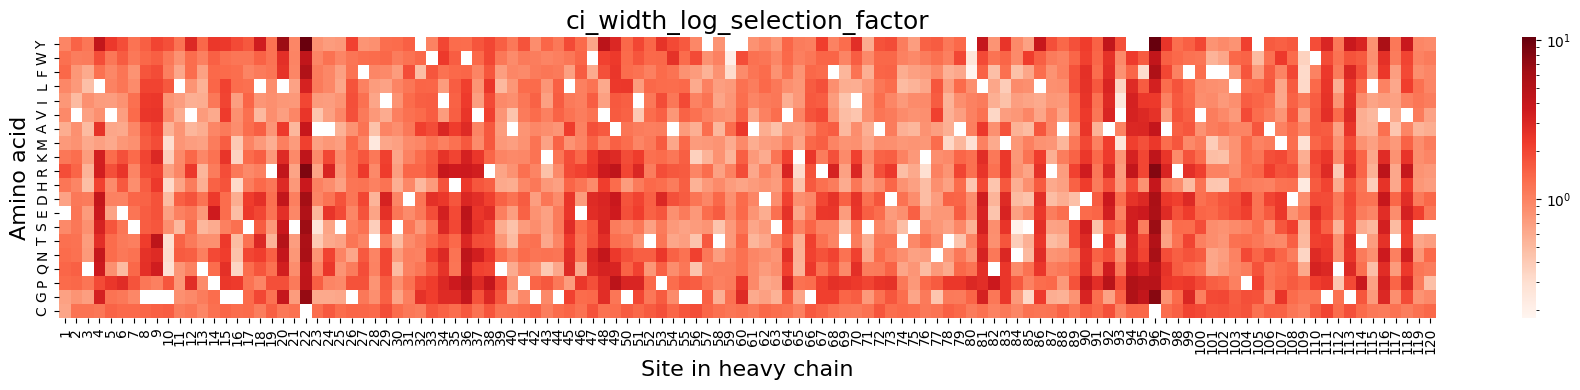

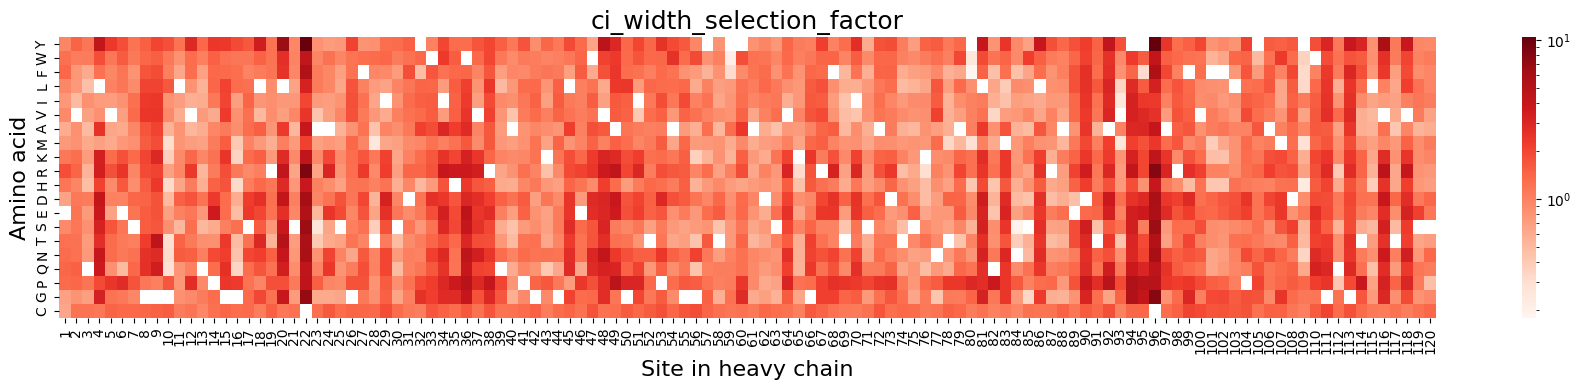

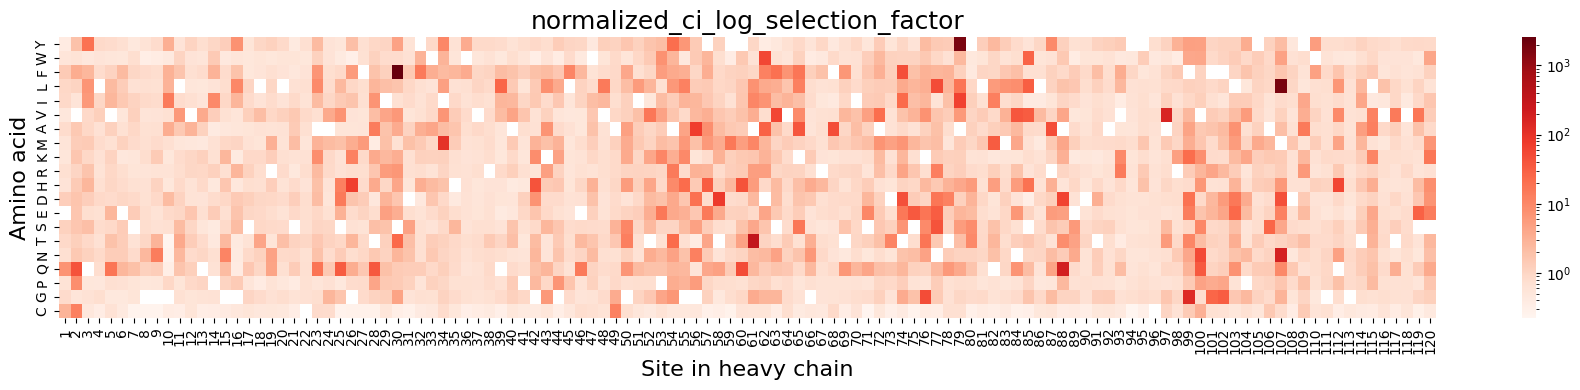

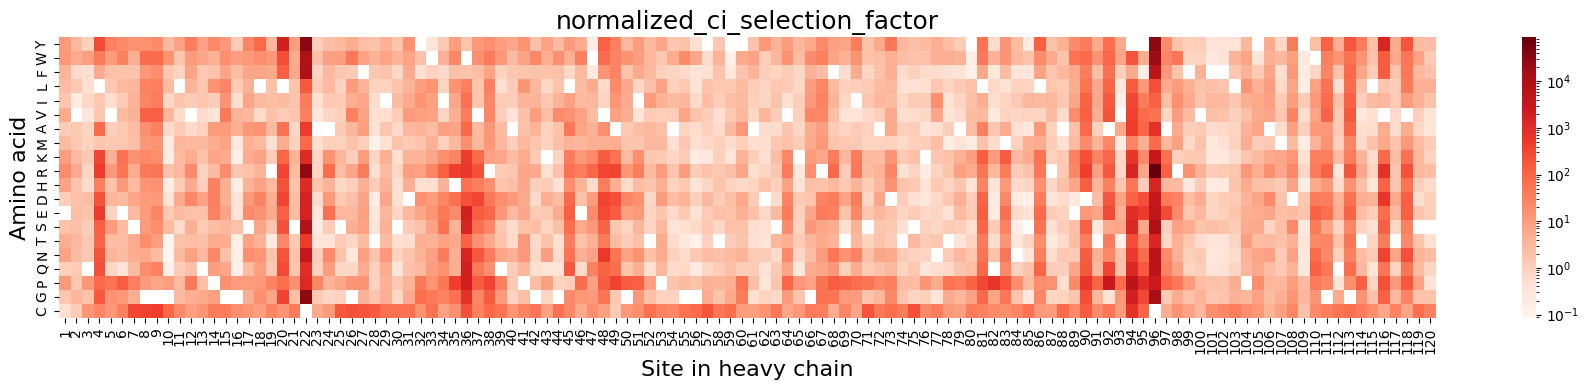

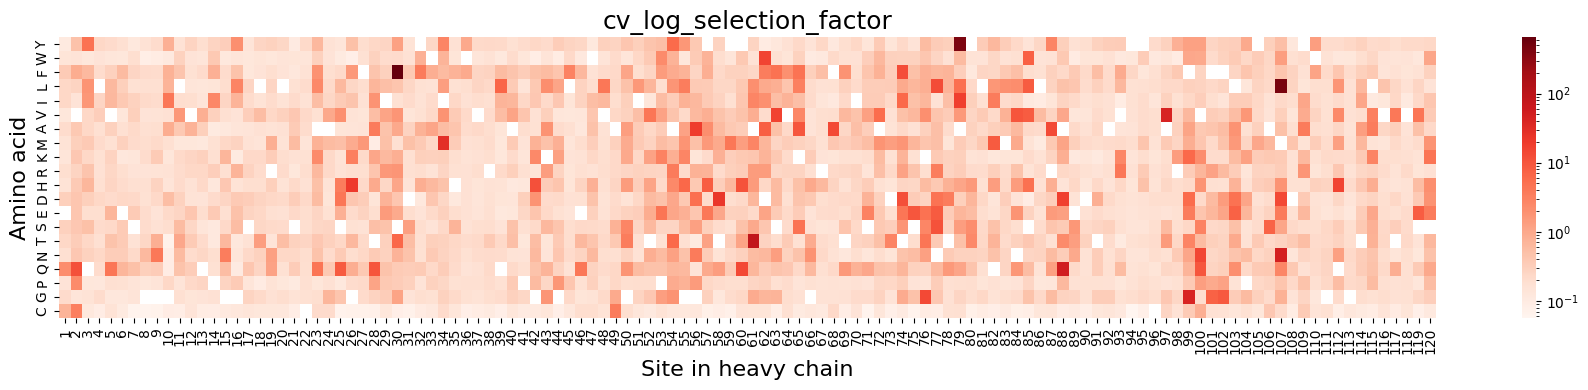

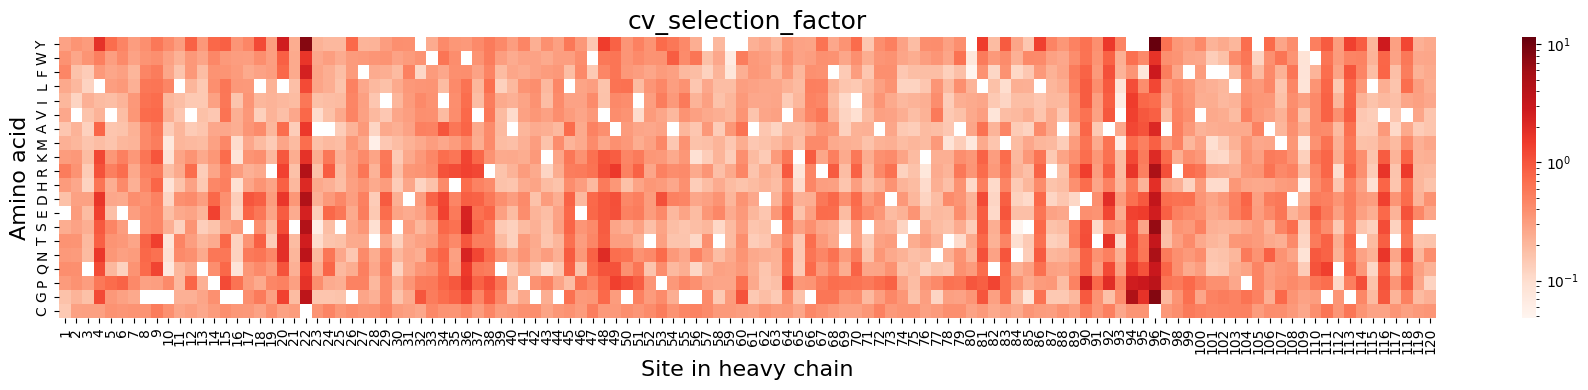

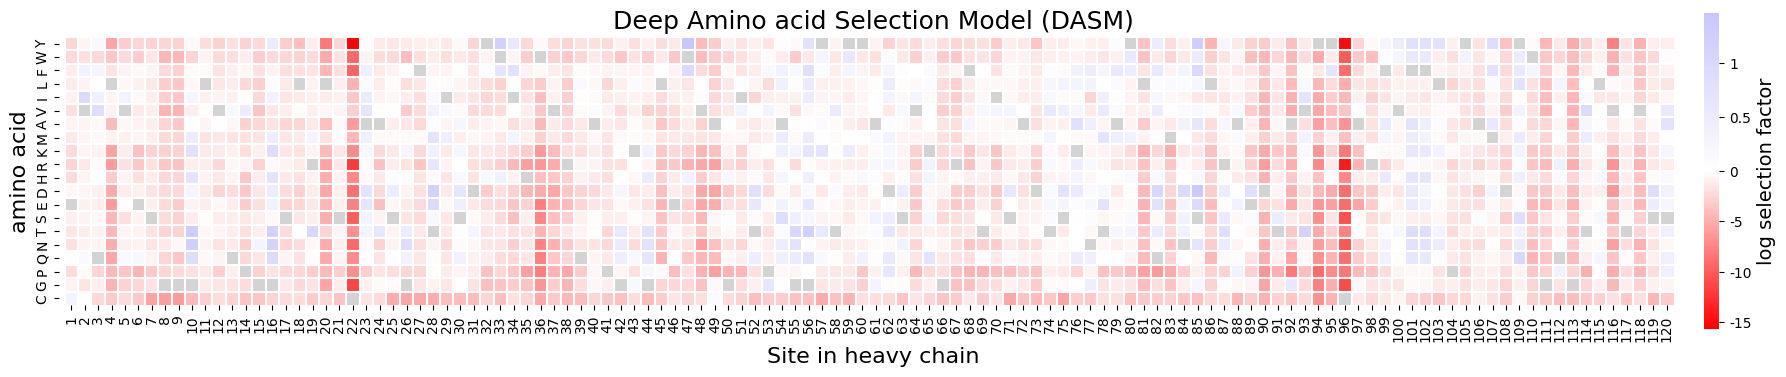

In [15]:
## plot similar to dasm plot predictions and compare
plot_log_heatmap(stats_df, 'ci_width_log_selection_factor', title='ci_width_log_selection_factor')
plot_log_heatmap(stats_df, 'ci_width_selection_factor', title='ci_width_selection_factor')

plot_log_heatmap(stats_df, 'normalized_ci_log_selection_factor', title='normalized_ci_log_selection_factor')
plot_log_heatmap(stats_df, 'normalized_ci_selection_factor', title='normalized_ci_selection_factor')

plot_log_heatmap(stats_df, 'cv_log_selection_factor', title='cv_log_selection_factor')
plot_log_heatmap(stats_df, 'cv_selection_factor', title='cv_selection_factor')

#plot_log_heatmap(ci_pivot, title='CI - confience interval width (90%)')
#plot_log_heatmap(norm_ci_pivot_fix_log, title='Normalized confidence interval (90%) with fixed log')


fig, ax = plt.subplots(1, 1, figsize=(18, 4))
make_heatmap(log_dasm_heavy_df, ax, "log selection factor")
ax.set_title('Deep Amino acid Selection Model (DASM)', fontsize=18)
ax.set_xlabel('Site in heavy chain', fontsize=16)
ax.set_ylabel('amino acid', fontsize=16)
plt.tight_layout()

## Visualization of confidence interval

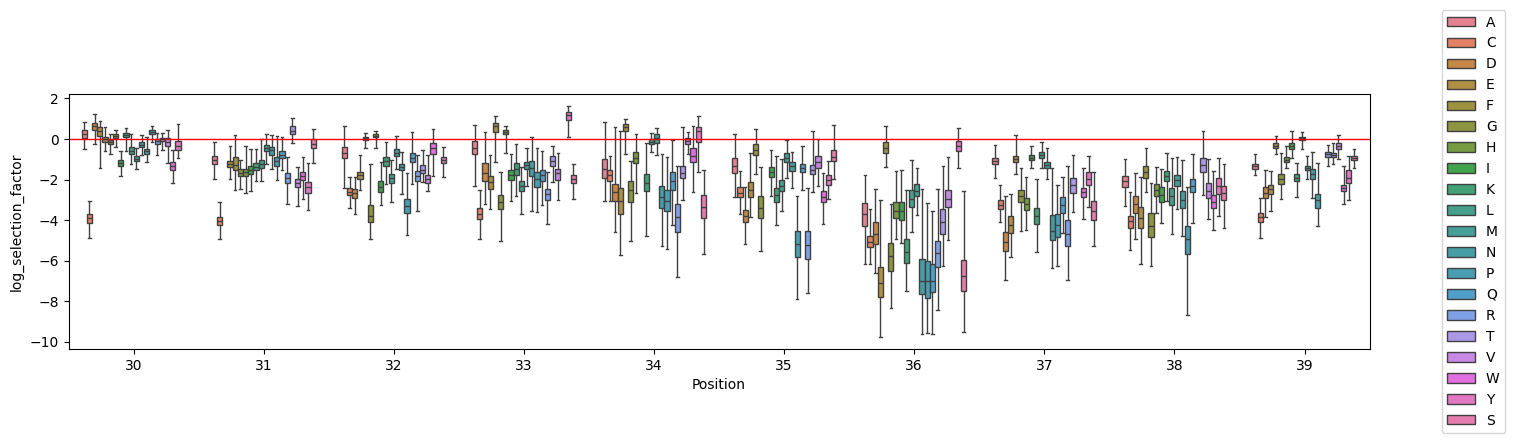

In [16]:
fig, ax = plt.subplots(figsize=(18, 4))
g = sns.boxplot(data=all_data[all_data.Position.isin(list(range(30, 40)))], x='Position', y='log_selection_factor', hue='AminoAcid', whis=(0,100),ax=ax)
g.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.axhline(y=0, color='r', linestyle='-', linewidth=1)



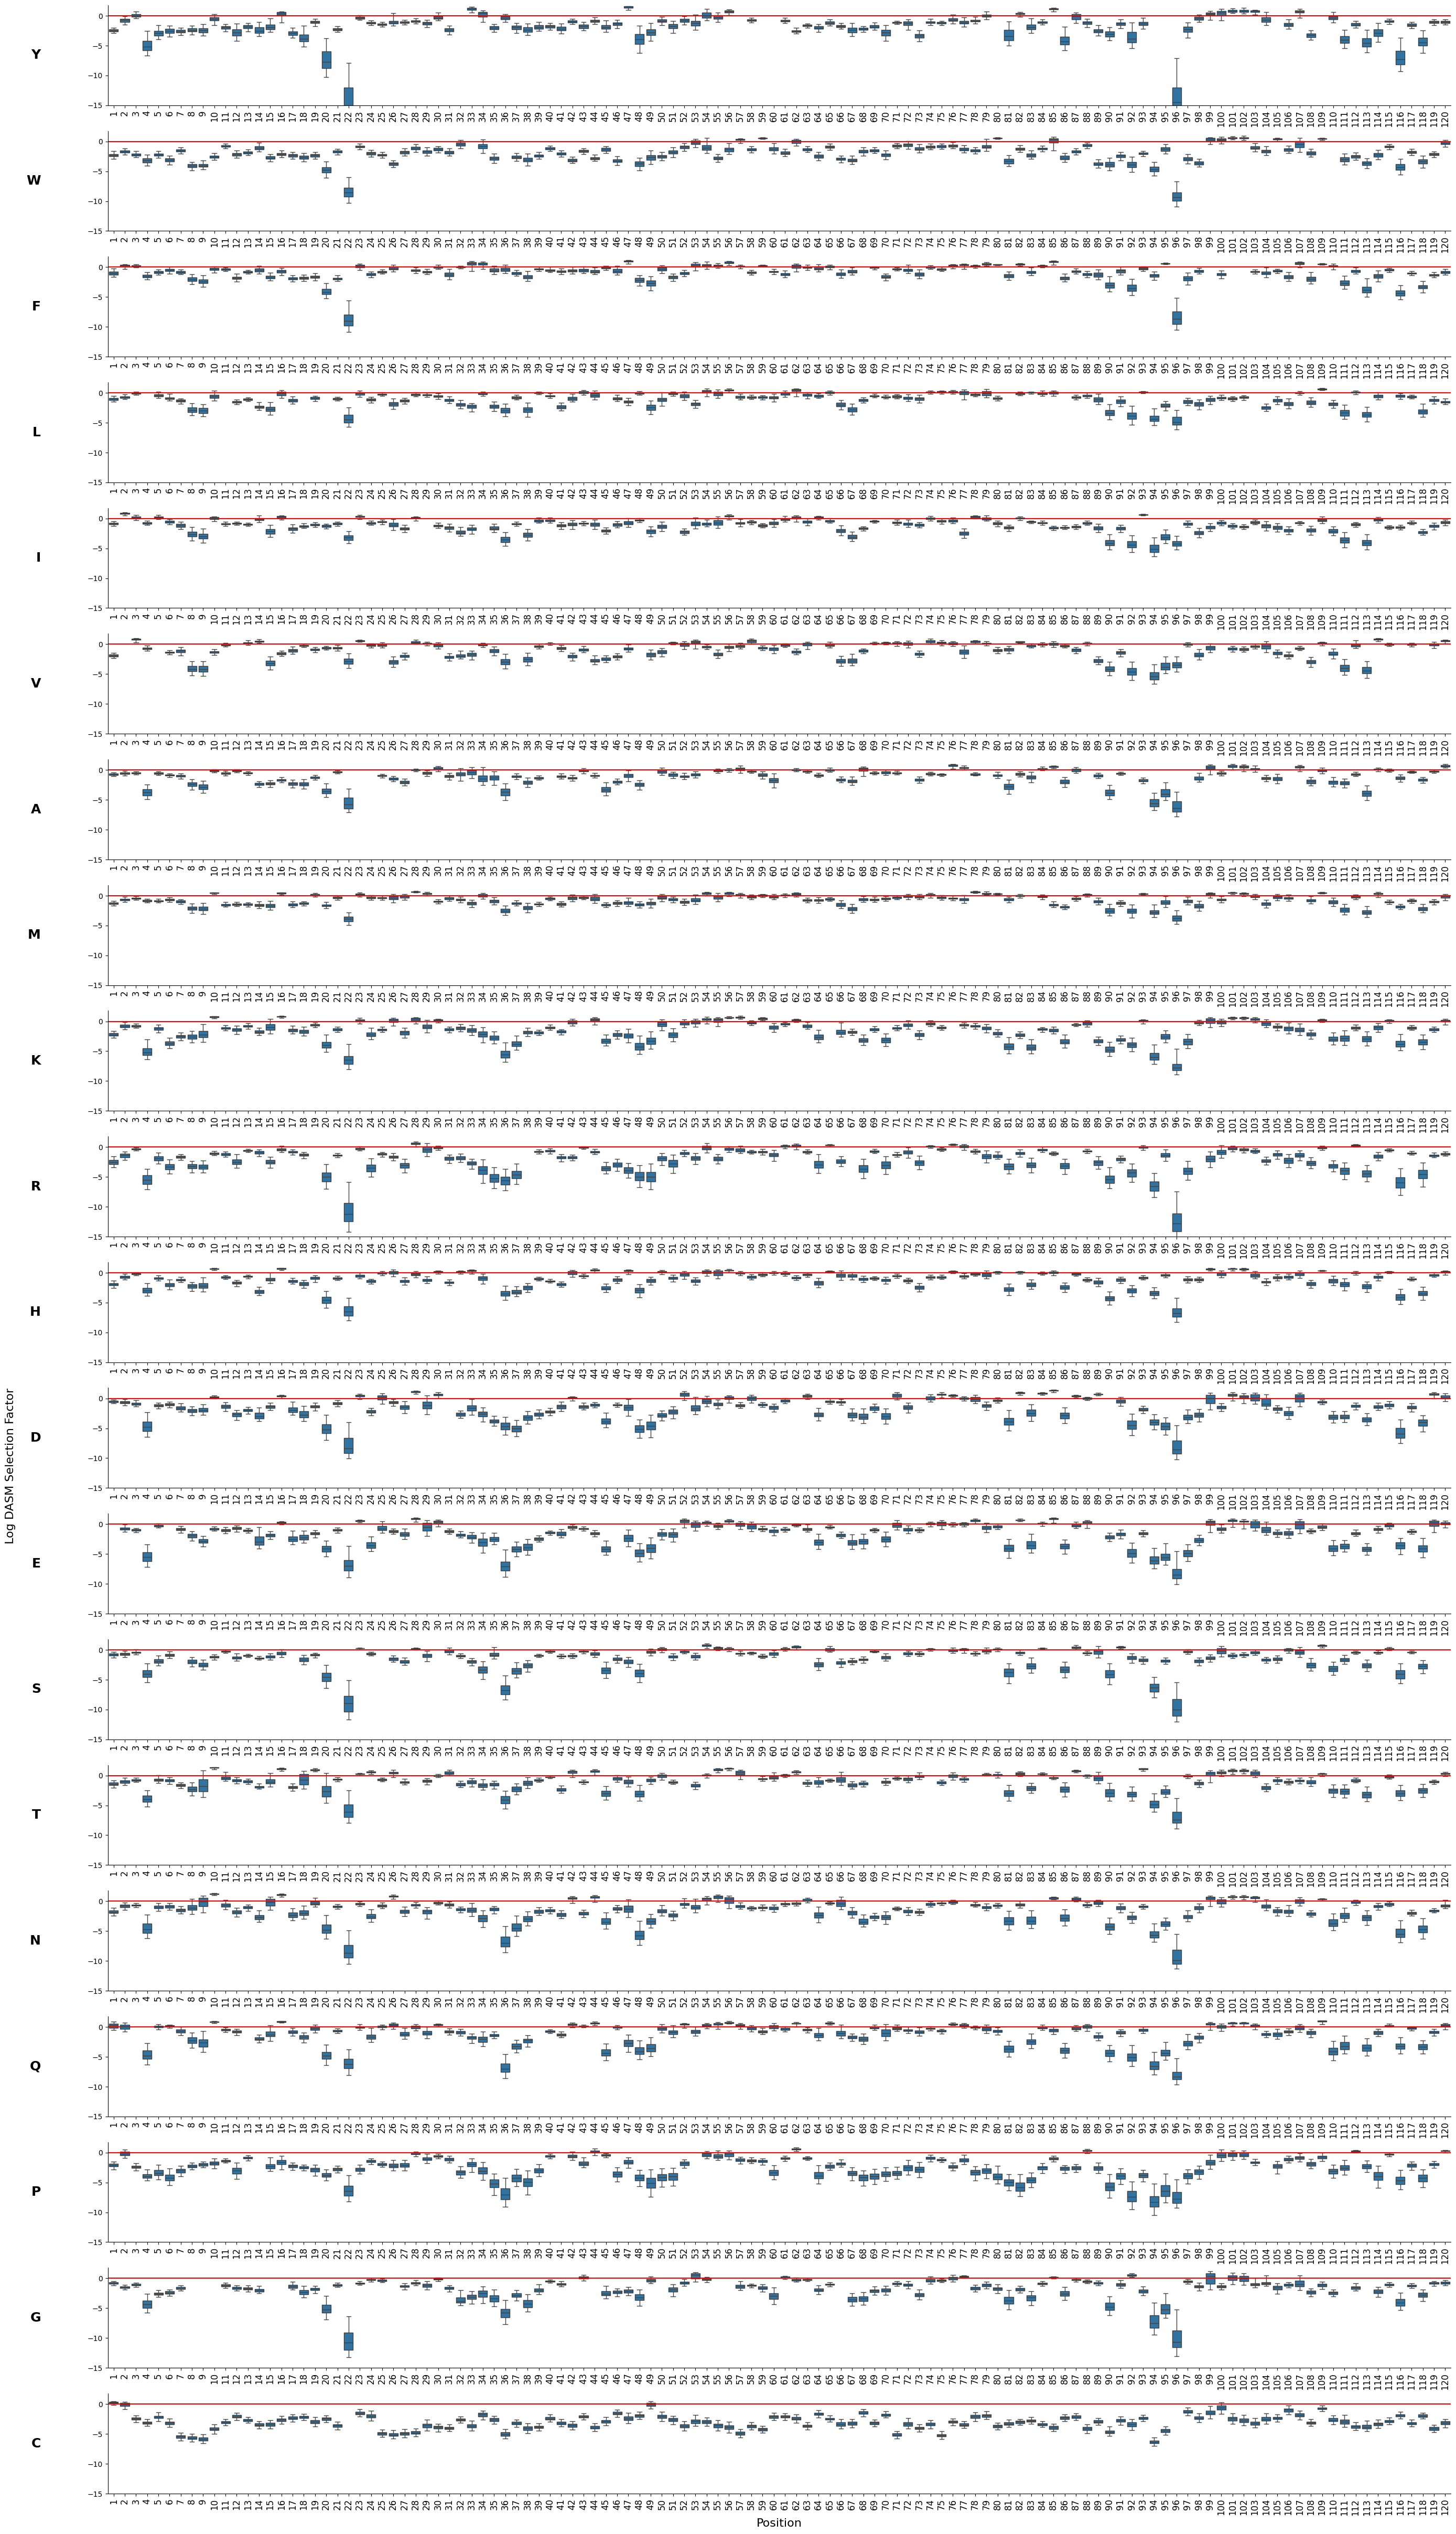

In [17]:
# Define the specific order for amino acids
amino_acid_order = list("YWFLIVAMKRHDESTNQPGC")

# Sort the dataframe according to amino acid order
all_data_sorted = all_data.copy()
all_data_sorted['AminoAcid_order'] = all_data_sorted['AminoAcid'].map({aa: i for i, aa in enumerate(amino_acid_order)})
all_data_sorted = all_data_sorted.sort_values('AminoAcid_order')

# Create a FacetGrid with ordered row parameter
g = sns.FacetGrid(
    all_data_sorted, 
    row='AminoAcid',
    row_order=amino_acid_order,  # Use the specified order
    height=2.8,
    aspect=10.0,
    sharey=True,
)

# Get the actual position categories from your data and ensure they're sorted numerically
unique_positions = sorted(all_data['Position'].unique(), key=lambda x: (pd.isna(x), x))

# Create a color map that assigns the same color to each position
num_positions = len(unique_positions)
color_map = dict(zip(unique_positions, sns.color_palette('Set2', num_positions)))

# Map a boxplot with consistent colors per position and proper handling of NaN values
def plot_boxes(x, y, **kwargs):
    # Get current data subset
    data = kwargs.get('data')
    
    # Default boxplot - but we'll sort the data first to make sure positions are in correct order
    ax = plt.gca()
    
    # Create a copy of the data and make sure the x variable is treated as category in the correct order
    plot_data = data.copy()
    
    # Define the order explicitly based on our sorted unique_positions
    order = [p for p in unique_positions if not pd.isna(p)]
    
    # Create the boxplot with explicit order
    sns.boxplot(x=x, y=y, data=plot_data, ax=ax, order=order, whis=[2.5, 97.5], showfliers=False)
    
    # Override the colors to ensure consistency
    for i, box in enumerate(ax.artists):
        if i < len(order):  # Safeguard against index errors
            position_value = order[i]
            if position_value in color_map:
                box_color = color_map[position_value]
                box.set_facecolor(box_color)
                box.set_edgecolor('black')
                
                # Also update the lines (whiskers, caps, etc.)
                for j in range(i*6, i*6+6):
                    if j < len(ax.lines):
                        ax.lines[j].set_color(box_color)
                        ax.lines[j].set_mfc(box_color)  # marker face color
                        ax.lines[j].set_mec(box_color)  # marker edge color

# Apply the custom plotting function
g.map_dataframe(plot_boxes, 'Position', 'log_selection_factor')

# Set y-limits for all subplots
g.set(ylim=(-15, all_data.log_selection_factor.max() + 0.1))  # Use the y-limits you provided

# Add a horizontal line at y=0 to all facets
g.map(plt.axhline, y=0, ls='-', c='red')

# Customize x-ticks to match the categorical positions
for i, ax in enumerate(g.axes.flat):
    # Filter out NaN positions for x-ticks
    valid_positions = [p for p in unique_positions if not pd.isna(p)]
    ax.set_xticks(range(len(valid_positions)))
    ax.set_xticklabels(valid_positions, rotation=90, fontsize=12)
    ax.xaxis.set_tick_params(labelbottom=True)
    
    # Add title on the left side of each plot
    if i < len(amino_acid_order):
        current_aa = amino_acid_order[i]
        # Remove any existing title
        ax.set_title("")
        # Add text at the left side
        ax.text(-0.05, 0.5, current_aa, transform=ax.transAxes, 
                ha='right', va='center', fontsize=18, fontweight='bold')

# Add a SHARED y-axis label for all subplots (on the left side)
g.fig.text(0.01, 0.5, 'Log DASM Selection Factor', va='center', rotation='vertical', fontsize=16)

# Remove individual y-axis labels (since we added a shared one)
g.set_axis_labels('Position', '', fontsize=16)

# Adjust layout to make room for the labels and titles
plt.tight_layout()
g.fig.subplots_adjust(left=0.08, bottom=0.15)  # Add space for labels

plt.show()

## Let's add the original prediction and look at correlations between the predictions and the uncertainty measurements, and between different uncertainty measurements

In [18]:
log_dasm_heavy_df_long = log_dasm_heavy_df.stack().reset_index()

log_dasm_heavy_df_long.columns = ['AminoAcid', 'Position', 'DASM_log_selection_factor']

stats_predict_df = pd.merge(stats_df, log_dasm_heavy_df_long, on=['AminoAcid', 'Position'], how='outer')
stats_predict_df['DASM_selection_factor'] = np.exp(stats_predict_df['DASM_log_selection_factor'])
stats_predict_df

Position AminoAcid  mean_log_selection_factor  std_log_selection_factor  \
0            1         A                  -0.739091                  0.153490   
1            2         A                  -0.550807                  0.213940   
2            3         A                  -0.533230                  0.125213   
3            4         A                  -3.738029                  0.697477   
4            5         A                  -0.539506                  0.157807   
...        ...       ...                        ...                       ...   
2275       116         Y                  -6.952983                  1.552131   
2276       117         Y                  -1.562326                  0.295870   
2277       118         Y                  -4.391829                  0.981246   
2278       119         Y                  -1.054357                  0.237177   
2279       120         Y                  -1.047289                  0.248777   

      mean_selection_factor  std_selection_factor  \
0                  0.483196              0.074610   
1                  0.589846              0.128198   
2                  0.591369              0.075697   
3                  0.030582              0.024058   
4                  0.590295              0.093251   
...                     ...                   ...   
2275               0.003767              0.010448   
2276               0.218913              0.064882   
2277               0.020299              0.025664   
2278               0.357914              0.080718   
2279               0.362107              0.094166   

      lower_bound_log_selection_factor  upper_bound_log_selection_factor  \
0                            -1.049719                         -0.456738   
1                            -0.959865                         -0.119646   
2                            -0.765856                         -0.270220   
3                            -4.960220                         -2.406559   
4                            -0.855428                         -0.218903   
...                                ...                               ...   
2275                         -9.357402                         -3.663010   
2276                         -2.146520                         -1.010958   
2277                         -6.245823                         -2.402196   
2278                         -1.587073                         -0.639037   
2279                         -1.483621                         -0.573455   

      lower_bound_selection_factor  upper_bound_selection_factor  \
0                        -1.049719                     -0.456738   
1                        -0.959865                     -0.119646   
2                        -0.765856                     -0.270220   
3                        -4.960220                     -2.406559   
4                        -0.855428                     -0.218903   
...                            ...                           ...   
2275                     -9.357402                     -3.663010   
2276                     -2.146520                     -1.010958   
2277                     -6.245823                     -2.402196   
2278                     -1.587073                     -0.639037   
2279                     -1.483621                     -0.573455   

      z_score_log_selection_factor_quantile_range  \
0                                        2.661329   
1                                        2.501738   
2                                        2.519784   
3                                        2.640794   
4                                        2.417047   
...                                           ...   
2275                                     2.504963   
2276                                     2.505529   
2277                                     2.498187   
2278                                     2.448536   
2279                                     2.520353   

      ci_width_log_selection_

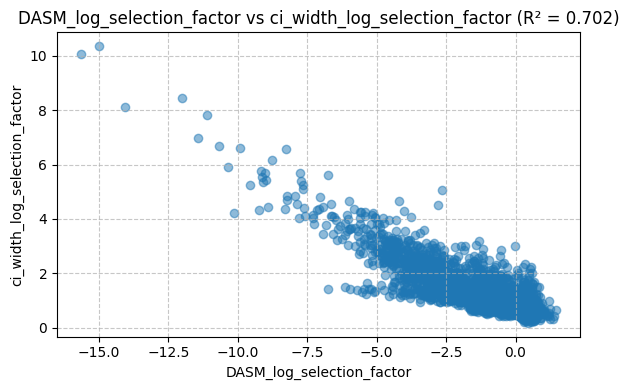

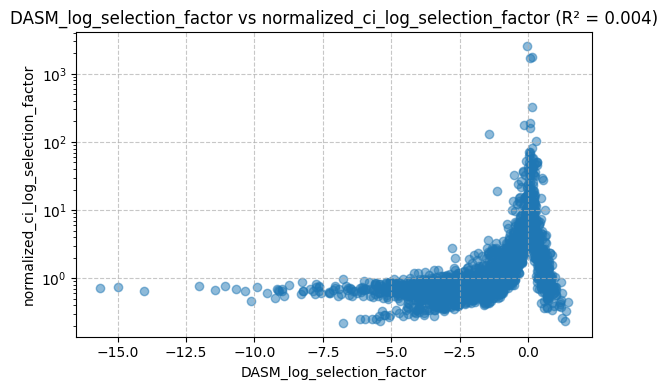

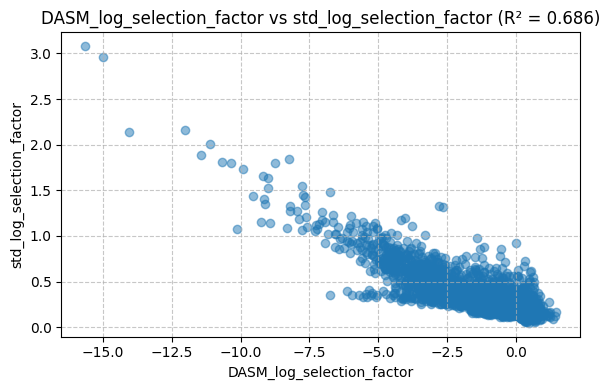

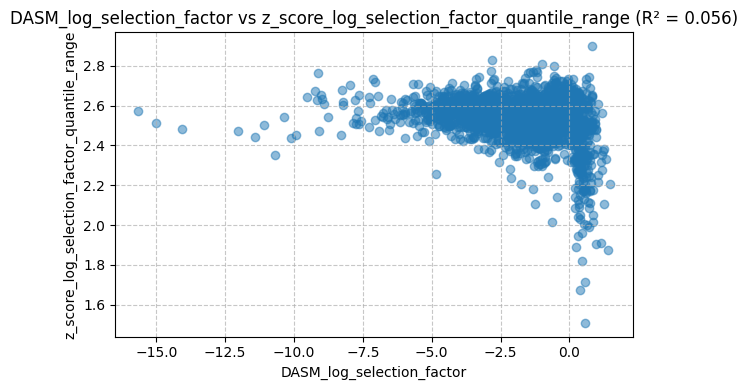

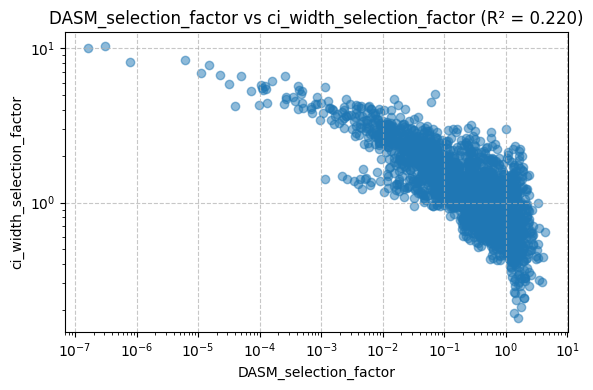

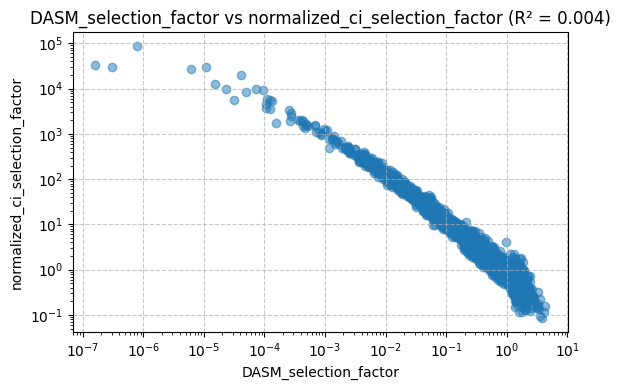

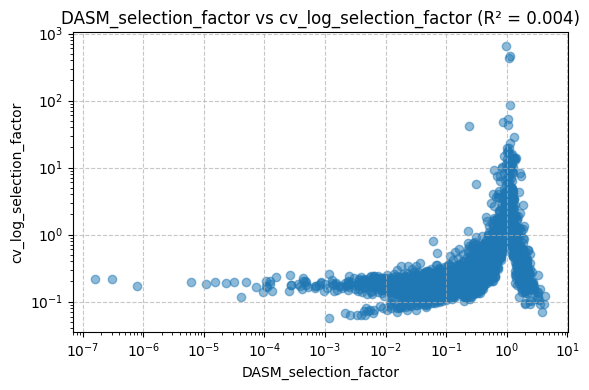

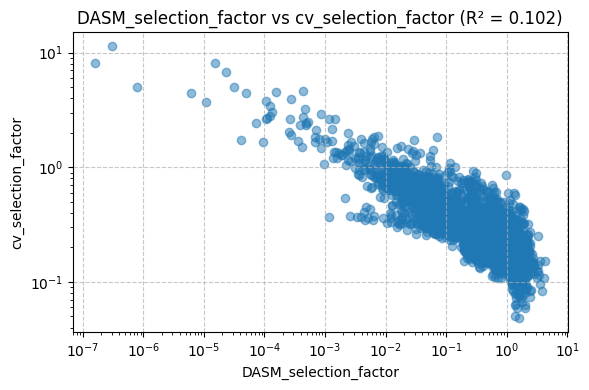

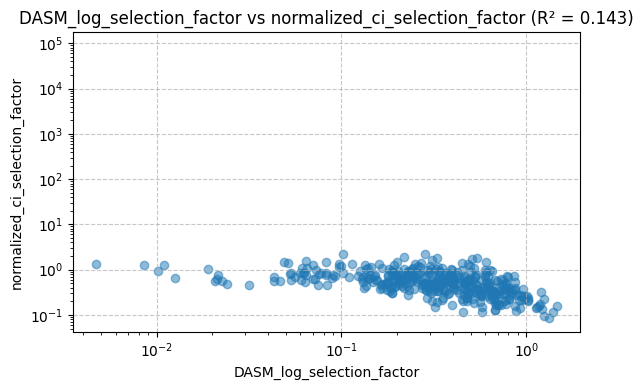

In [19]:
def plot_correlation(df, x_col, y_col, log_x=False, log_y=True, figsize=(6, 4)):
    """Plot scatter correlation between two columns with optional log scales."""
    plt.figure(figsize=figsize)
    
    # Calculate correlation statistics
    mask = df[[x_col, y_col]].notna().all(axis=1)
    x, y = df.loc[mask, x_col], df.loc[mask, y_col]
    r_value = np.corrcoef(x, y)[0, 1]
    r_squared = r_value**2
    
    # Create scatter plot
    plt.scatter(x, y, alpha=0.5)
    
    # Set scales
    if log_x: plt.xscale('log')
    if log_y: plt.yscale('log')
    
    # Add labels and annotation
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f"{x_col} vs {y_col} (R² = {r_squared:.3f})")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot all your correlations
correlations = [
    ('Prediction', 'normalized_ci'),
    ('Prediction', 'normalized_ci_fix_log'),
    ('Prediction', 'ci_width'),
    ('Prediction', 'cv'),
    ('normalized_ci', 'cv', True, True)  # x_log=True, y_log=True for this pair
]

plot_correlation(stats_predict_df, 'DASM_log_selection_factor', 'ci_width_log_selection_factor', log_x=False, log_y=False)
plot_correlation(stats_predict_df, 'DASM_log_selection_factor', 'normalized_ci_log_selection_factor', log_x=False, log_y=True)
plot_correlation(stats_predict_df, 'DASM_log_selection_factor', 'std_log_selection_factor', log_x=False, log_y=False)
plot_correlation(stats_predict_df, 'DASM_log_selection_factor', 'z_score_log_selection_factor_quantile_range', log_x=False, log_y=False)



plot_correlation(stats_predict_df, 'DASM_selection_factor', 'ci_width_selection_factor', log_x=True, log_y=True)
plot_correlation(stats_predict_df, 'DASM_selection_factor', 'normalized_ci_selection_factor', log_x=True, log_y=True)

plot_correlation(stats_predict_df, 'DASM_selection_factor', 'cv_log_selection_factor', log_x=True, log_y=True)
plot_correlation(stats_predict_df, 'DASM_selection_factor', 'cv_selection_factor', log_x=True, log_y=True)



plot_correlation(stats_predict_df, 'DASM_log_selection_factor', 'normalized_ci_selection_factor', log_x=True, log_y=True)

### interim conclusions
Normalized CI and coefficient of variation look to be almost the same just on different scales.

Both confidence intervals and normalized confidence intervals are correlated with the predictions:
- CI is lowest = most confident around 0 and positive selection factors (we only have low positive ones, unlike the negative)
- Normalized CI has the most confidence (is smallest) in the more extreme selection factors - both positive and negative, and less confidence around 0 selection factors.

Do one of these correlations make sense or does this mean that these measures not good enough?



In [20]:
# make sure predictions are inside the 95% confidence interval - they always are
stats_predict_df['ground_truth_in_0.95_range'] = (stats_predict_df['lower_bound_log_selection_factor'] <= stats_predict_df['DASM_log_selection_factor']) & (stats_predict_df['upper_bound_log_selection_factor'] >= stats_predict_df['DASM_log_selection_factor'])

stats_predict_df['ground_truth_in_0.95_range'].value_counts(normalize=True)

ground_truth_in_0.95_range
True    1.0
Name: proportion, dtype: float64

In [21]:
all_data.groupby(['Position', 'AminoAcid'])['log_selection_factor'].quantile([0.25, 0.75])

Position  AminoAcid      
1         A          0.25   -0.833159
                     0.75   -0.636387
          C          0.25    0.169634
                     0.75    0.343299
          D          0.25   -0.647805
                               ...   
120       V          0.75    0.633772
          W          0.25   -0.440725
                     0.75   -0.058075
          Y          0.25   -1.238512
                     0.75   -0.875895
Name: log_selection_factor, Length: 4560, dtype: float64

In [22]:
def in_ci(all_mc_data, predictions, lower_bound=0.025, upper_bound=0.975):
    all_mc_data = all_mc_data.groupby(['AminoAcid', 'Position'])['log_selection_factor'].quantile([lower_bound, upper_bound]).unstack().reset_index().rename(columns={lower_bound: 'lower_bound', upper_bound: 'upper_bound'})
    merged = pd.merge(all_mc_data, predictions, on=['AminoAcid', 'Position'], how='outer')
    print(merged['DASM_log_selection_factor'].between(merged['lower_bound'], merged['upper_bound']).value_counts(normalize=True))

in_ci(all_data, log_dasm_heavy_df_long, 0.1, 0.9)
in_ci(all_data, log_dasm_heavy_df_long, 0.05, 0.95)
in_ci(all_data, log_dasm_heavy_df_long, 0.25, 0.75)

True     0.996053
False    0.003947
Name: proportion, dtype: float64
True    1.0
Name: proportion, dtype: float64
True     0.772807
False    0.227193
Name: proportion, dtype: float64


The confidence intervals we are testing do not include the same precent of the data, let's try and play with the dropout probability.

In [23]:
# plot confidence intervals from simulated model and predictions from original model

MC_DROPOUT_ITERATIONS = 500

def run_mc_dropout_vary_dropout(heavy_seq, model_path, 
                  num_predictions=500, device='cpu', dropout_prob=0.5):
    # Load DASM model and put in training mode
    crepe = load_crepe(localify(model_path), device=device)
    
    # Change dropout probability in all dropout layers
    for module in crepe.model.modules():
        if isinstance(module, torch.nn.Dropout):
            module.p = dropout_prob
    
    crepe.model.train()
    crepe = heavy_chain_shim(crepe)

    # Rest of the function remains the same
    # Initialize a list to store all predictions
    dasm_heavy_predictions = []

    # Run the model multiple times and save predictions
    for i in range(num_predictions):
        # Get raw predictions
        [dasm_heavy] = crepe([heavy_seq])
        
        # Save log-transformed predictions
        log_dasm_heavy = np.log(dasm_heavy).T
        log_dasm_heavy_df = df_of_arr(log_dasm_heavy)
        assign_wt(log_dasm_heavy_df, heavy_seq, np.nan)
        log_dasm_heavy_df_long = log_dasm_heavy_df.stack().reset_index()
        log_dasm_heavy_df_long.columns = ['AminoAcid', 'Position', 'log_selection_factor']
        
        # Add sample identifier
        log_dasm_heavy_df_long['Sample'] = i
        
        dasm_heavy_predictions.append(log_dasm_heavy_df_long)

    # Combine all samples
    all_data = pd.concat(dasm_heavy_predictions, ignore_index=True)
    return all_data

def wrap_run_mc_dropout_vary_dropout(output_path, dropout_prob):
    # Load DASM model
    crepe_original = load_crepe(localify("DASM_TRAINED_MODELS_DIR/dasm_4m-v1jaffeCC+v1tangCC-joint"))
    crepe_original = heavy_chain_shim(crepe_original)

    stats_big_df = []
    if os.path.exists(output_path):
        print('file exists, skipping')
        return pd.read_csv(output_path) 
    else:
        for seq in tqdm.tqdm([heavy_wt]):
            [dasm_heavy_original] = crepe_original([seq])
            log_dasm_heavy_original = (np.log(dasm_heavy_original).T)
            log_dasm_heavy_df = df_of_arr(log_dasm_heavy_original)
            assign_wt(log_dasm_heavy_df, seq, np.nan)
            all_data = run_mc_dropout_vary_dropout(seq, model_path="DASM_TRAINED_MODELS_DIR/dasm_4m-v1jaffeCC+v1tangCC-joint", num_predictions=MC_DROPOUT_ITERATIONS, device='cuda', dropout_prob=dropout_prob)
            stats_df = calc_mc_dropout_stats2(all_data)
            
            # add ground truth predictions to mc droupout on simulations data
            log_dasm_heavy_df_long = log_dasm_heavy_df.stack().reset_index()
            log_dasm_heavy_df_long.columns = ['AminoAcid', 'Position', 'DASM_log_selection_factor']

            stats_predict_df = pd.merge(stats_df, log_dasm_heavy_df_long, on=['AminoAcid', 'Position'], how='outer')
            stats_predict_df['ground_truth_in_0.95_range'] = (stats_predict_df['lower_bound_log_selection_factor'] <= stats_predict_df['DASM_log_selection_factor']) & (stats_predict_df['upper_bound_log_selection_factor'] >= stats_predict_df['DASM_log_selection_factor'])
            stats_predict_df['flipped_signs'] = ((stats_predict_df['lower_bound_log_selection_factor'] > 0) & (stats_predict_df['upper_bound_log_selection_factor'] > 0) & (stats_predict_df['DASM_log_selection_factor'] < 0))|((stats_predict_df['lower_bound_log_selection_factor'] < 0) & (stats_predict_df['upper_bound_log_selection_factor'] < 0) & (stats_predict_df['DASM_log_selection_factor'] > 0))

            stats_predict_df['test_seq'] = seq
            stats_big_df.append(stats_predict_df)

        df = pd.concat(stats_big_df)
        df.to_csv(output_path, index=False)
        return df

# Calculate statistics
def calc_mc_dropout_stats2(all_data):
    # Group by Position and AminoAcid to calculate across samples
    grouped = all_data.groupby(['Position', 'AminoAcid'])

    # Calculate mean and std
    stats_df = grouped['log_selection_factor'].agg(['mean', 'std']).reset_index().rename(columns={'mean': 'mean_log_selection_factor', 'std': 'std_log_selection_factor'})

    # Add small epsilon to avoid division by zero
    epsilon = 1e-5

    # Calculate percentiles
    percentiles = grouped['log_selection_factor'].quantile([0.025, 0.975]).unstack()
    percentiles.columns = ['lower_bound', 'upper_bound']
    percentiles = percentiles.reset_index().rename(columns={'lower_bound': 'lower_bound_log_selection_factor', 'upper_bound': 'upper_bound_log_selection_factor'})

    # Merge with stats_df
    stats_df = pd.merge(stats_df, percentiles, on=['Position', 'AminoAcid'])

    # Step 4: Calculate all uncertainty measures
    stats_df['ci_width_log_selection_factor'] = stats_df['upper_bound_log_selection_factor'] - stats_df['lower_bound_log_selection_factor']
    stats_df['normalized_ci_log_selection_factor'] = stats_df['ci_width_log_selection_factor'] / (np.abs(stats_df['mean_log_selection_factor']) + epsilon)
    #stats_df['cv_log_selection_factor'] = stats_df['std_log_selection_factor'] / (np.abs(stats_df['mean_log_selection_factor']) + epsilon)


    return stats_df



## default dropout
results_default = wrap_run_mc_dropout_vary_dropout(localify('DATA_DIR/uncertainty/functional_uncertainty/koenig_dropout_0.1.csv'), dropout_prob=0.1)

results_high_dropout = wrap_run_mc_dropout_vary_dropout(localify('DATA_DIR/uncertainty/functional_uncertainty/koenig_dropout_0.5.csv'), dropout_prob=0.5)

results_low_dropout = wrap_run_mc_dropout_vary_dropout(localify('DATA_DIR/uncertainty/functional_uncertainty/koenig_dropout_0.05.csv'), dropout_prob=0.05)

results_03_dropout = wrap_run_mc_dropout_vary_dropout(localify('DATA_DIR/uncertainty/functional_uncertainty/koenig_dropout_0.3.csv'), dropout_prob=0.3)

results_04_dropout = wrap_run_mc_dropout_vary_dropout(localify('DATA_DIR/uncertainty/functional_uncertainty/koenig_dropout_0.4.csv'), dropout_prob=0.4)

results_035_dropout = wrap_run_mc_dropout_vary_dropout(localify('DATA_DIR/uncertainty/functional_uncertainty/koenig_dropout_0.35.csv'), dropout_prob=0.35)

file exists, skipping
file exists, skipping
file exists, skipping
file exists, skipping
file exists, skipping
file exists, skipping


Dropout prob: 0.1
ground_truth_in_0.95_range
True    1.0
Name: proportion, dtype: float64
Dropout prob: 0.5
ground_truth_in_0.95_range
True     0.805702
False    0.194298
Name: proportion, dtype: float64
Dropout prob: 0.3
ground_truth_in_0.95_range
True     0.975
False    0.025
Name: proportion, dtype: float64
Dropout prob: 0.4
ground_truth_in_0.95_range
True     0.912281
False    0.087719
Name: proportion, dtype: float64
Dropout prob: 0.35
ground_truth_in_0.95_range
True     0.948246
False    0.051754
Name: proportion, dtype: float64


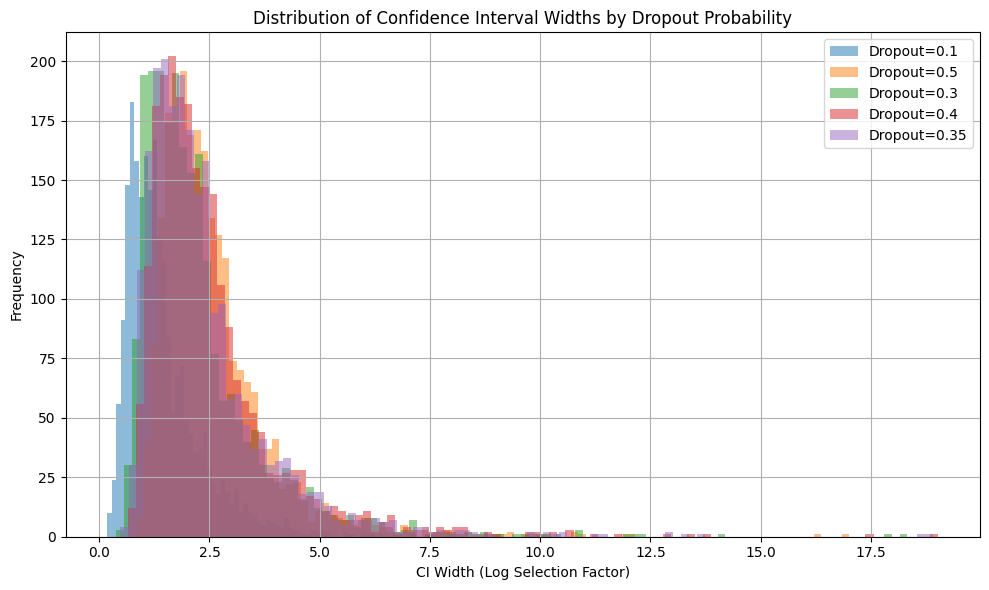

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))

for i, stats in zip([0.1, 0.5, 0.3, 0.4, 0.35], [results_default, results_high_dropout, results_03_dropout, results_04_dropout, results_035_dropout]):
    print('Dropout prob: {}'.format(i))
    print(stats['ground_truth_in_0.95_range'].value_counts(normalize=True))
    stats.ci_width_log_selection_factor.hist(bins=100, alpha=0.5, label=f"Dropout={i}", ax=ax)

plt.legend()  # Display the legend with the labels
plt.xlabel('CI Width (Log Selection Factor)')
plt.ylabel('Frequency')
plt.title('Distribution of Confidence Interval Widths by Dropout Probability')
plt.tight_layout()
plt.show()

# Compare to Koenig dataset - can any of these uncertainty measures tell us when our predictions are closer to the functional measurements?

'EVQLVESGGGLVQPGGSLRLSCAASGFTISDYWIHWVRQAPGKGLEWVAGITPAGGYTYYADSVKGRFTISADTSKNTAYLQMNSLRAEDTAVYYCARFVFFLPYAMDYWGQGTLVTVSS'

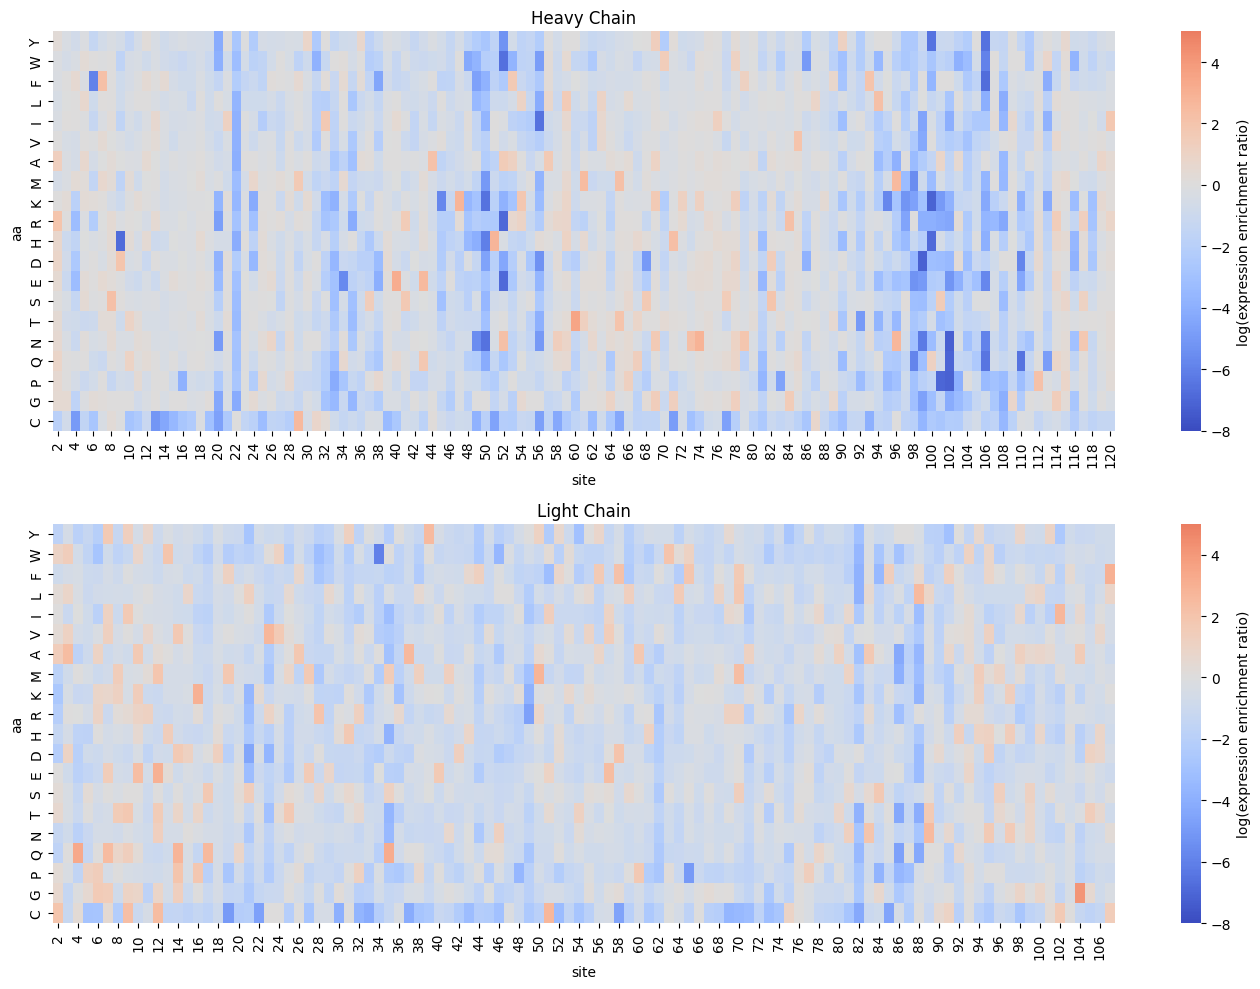

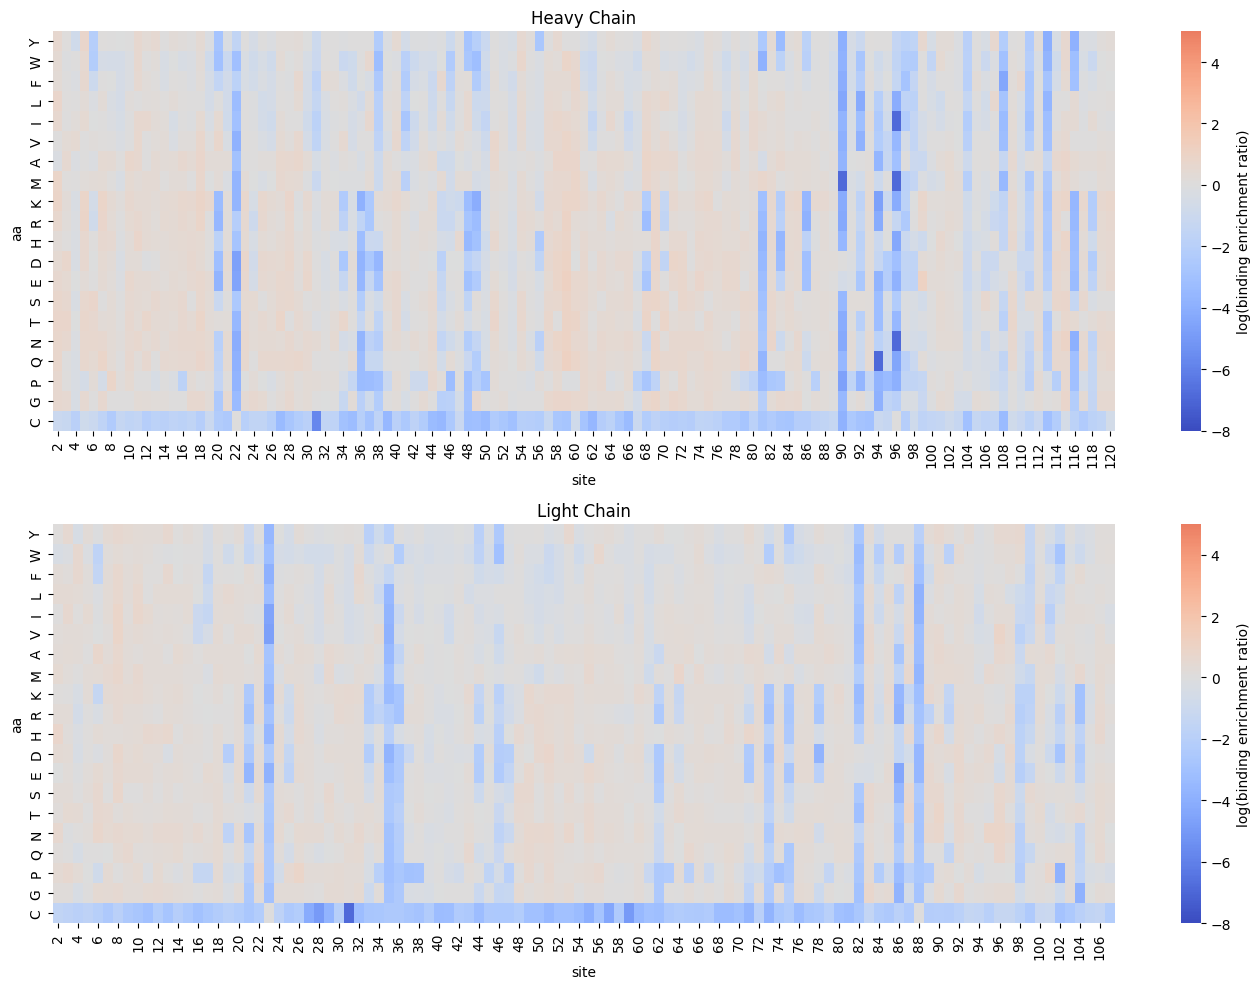

In [25]:
## compare to koenig dataset

## Binding Data
binding_dataset = KoenigDataset(
    localify("~/re/FLAb/data/binding/Koenig2017_g6_Kd.csv"),
    fitness_column="fitness",
    fitness_label="expression enrichment ratio",
    log_transform=True,
)

#binding_dataset.plot_fitness_histograms()
binding_dataset.plot_heatmaps()
## Expression Data
expr_dataset = KoenigDataset(
    localify("~/re/FLAb/data/expression/Koenig2017_g6_er.csv"), 
    fitness_column="fitness",
    fitness_label="binding enrichment ratio",
    log_transform=True,
    )

#expr_dataset.plot_fitness_histograms()
expr_dataset.plot_heatmaps()
heavy_wt = expr_dataset.heavy_consensus
#light_wt = expr_dataset.light_consensus

heavy_wt

In [26]:
epsilon = 1e-10

koenig_expr_df = expr_dataset._create_dms_style_df('heavy')
koenig_binding_df = binding_dataset._create_dms_style_df('heavy')

koenig_expr_df = koenig_expr_df.stack().reset_index().rename(columns={'aa':'AminoAcid', 'site':'Position', 0:'Expression'})
koenig_expr_df['Expression_log'] = np.log(koenig_expr_df['Expression'] + epsilon)

koenig_binding_df = koenig_binding_df.stack().reset_index().rename(columns={'aa':'AminoAcid', 'site':'Position', 0:'Binding'})
koenig_binding_df['Binding_log'] = np.log(koenig_binding_df['Binding'] + epsilon)


In [27]:
## add uncertainty and dasm predictions to koenig seq

stats_predict_df = pd.merge(stats_predict_df, koenig_expr_df, on=['AminoAcid', 'Position'], how='outer')
stats_predict_df = pd.merge(stats_predict_df, koenig_binding_df, on=['AminoAcid', 'Position'], how='outer')





In [28]:
stats_predict_df

Position AminoAcid  mean_log_selection_factor  std_log_selection_factor  \
0            1         A                  -0.739091                  0.153490   
1            2         A                  -0.550807                  0.213940   
2            3         A                  -0.533230                  0.125213   
3            4         A                  -3.738029                  0.697477   
4            5         A                  -0.539506                  0.157807   
...        ...       ...                        ...                       ...   
2394       116         Y                  -6.952983                  1.552131   
2395       117         Y                  -1.562326                  0.295870   
2396       118         Y                  -4.391829                  0.981246   
2397       119         Y                  -1.054357                  0.237177   
2398       120         Y                  -1.047289                  0.248777   

      mean_selection_factor  std_selection_factor  \
0                  0.483196              0.074610   
1                  0.589846              0.128198   
2                  0.591369              0.075697   
3                  0.030582              0.024058   
4                  0.590295              0.093251   
...                     ...                   ...   
2394               0.003767              0.010448   
2395               0.218913              0.064882   
2396               0.020299              0.025664   
2397               0.357914              0.080718   
2398               0.362107              0.094166   

      lower_bound_log_selection_factor  upper_bound_log_selection_factor  \
0                            -1.049719                         -0.456738   
1                            -0.959865                         -0.119646   
2                            -0.765856                         -0.270220   
3                            -4.960220                         -2.406559   
4                            -0.855428                         -0.218903   
...                                ...                               ...   
2394                         -9.357402                         -3.663010   
2395                         -2.146520                         -1.010958   
2396                         -6.245823                         -2.402196   
2397                         -1.587073                         -0.639037   
2398                         -1.483621                         -0.573455   

      lower_bound_selection_factor  upper_bound_selection_factor  ...  \
0                        -1.049719                     -0.456738  ...   
1                        -0.959865                     -0.119646  ...   
2                        -0.765856                     -0.270220  ...   
3                        -4.960220                     -2.406559  ...   
4                        -0.855428                     -0.218903  ...   
...                            ...                           ...  ...   
2394                     -9.357402                     -3.663010  ...   
2395                     -2.146520                     -1.010958  ...   
2396                     -6.245823                     -2.402196  ...   
2397                     -1.587073                     -0.639037  ...   
2398                     -1.483621                     -0.573455  ...   

      normalized_ci_selection_factor  cv_log_selection_factor  \
0                           1.227180                 0.207671   
1                           1.424448                 0.388405   
2                           0.838103                 0.234816   
3                          83.474195                 0.186589   
4                           1.078299                 0.292497   
...                              ...                      ...   
2394                     1507.510680                 0.223232   
2395                        5.187043                 0.189376   
2396                 

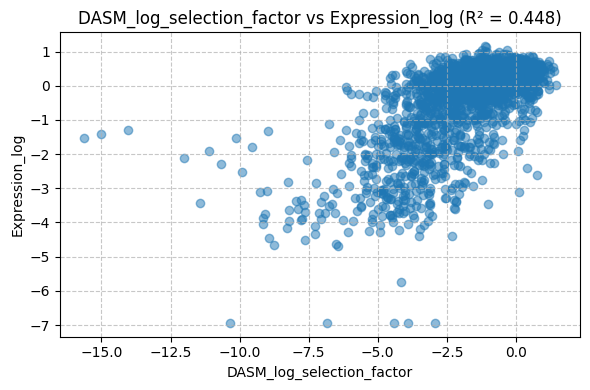

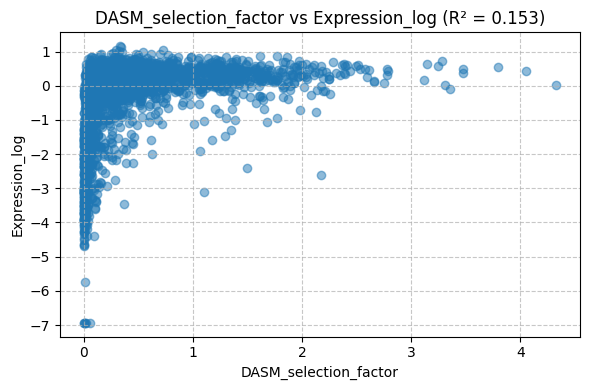

In [29]:
# does DASM log selection factor or raw selection factor correlate better with expression?

plot_correlation(stats_predict_df, 'DASM_log_selection_factor', 'Expression_log', log_x=False, log_y=False)
plot_correlation(stats_predict_df, 'DASM_selection_factor', 'Expression_log', log_x=False, log_y=False)

#### answer - log selection factor - so we will use that

## separate data into groups according to uncertainty level and test predictions according to expression - which measure works best at separating between better and worse predictions?

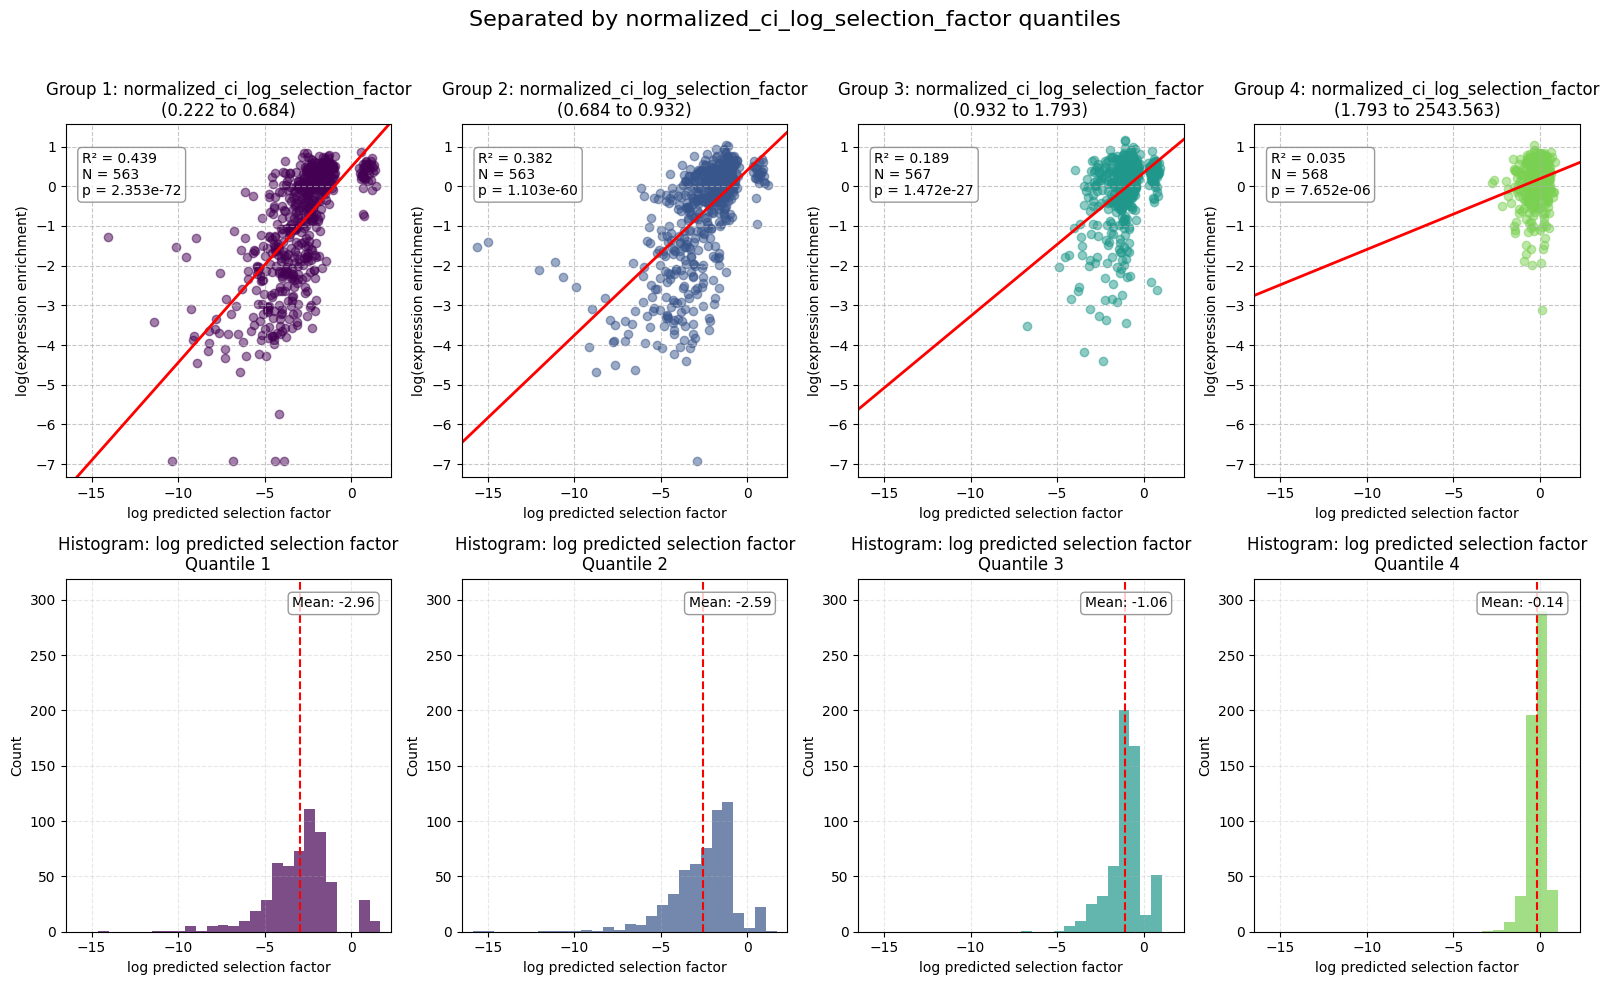

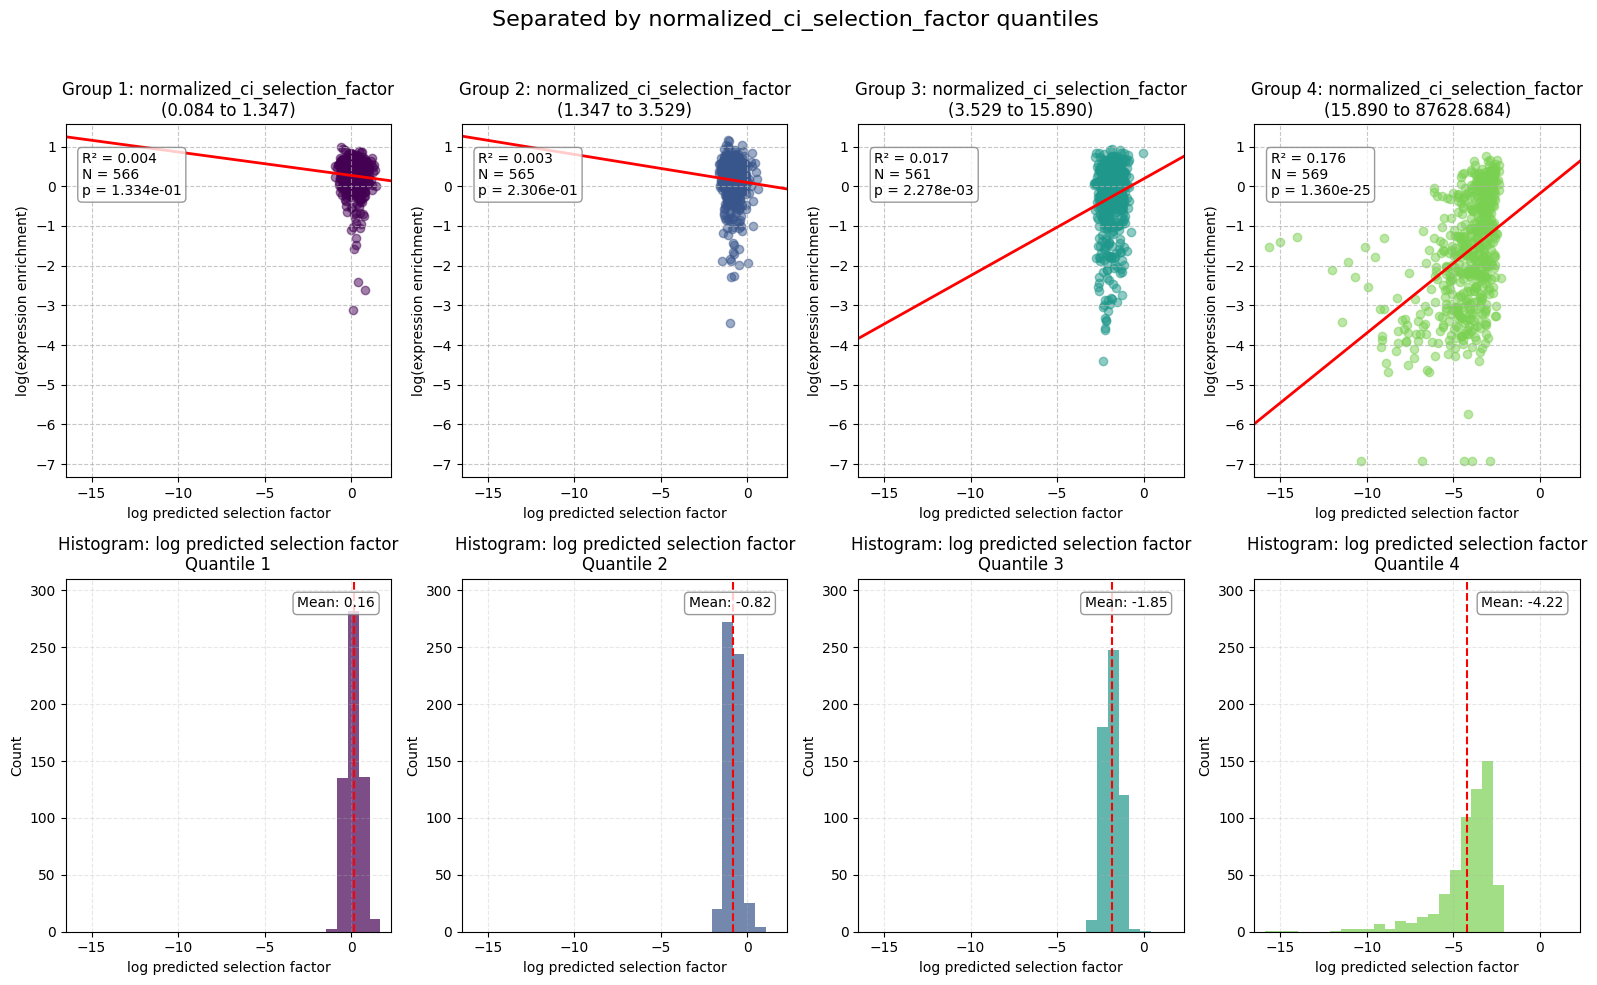

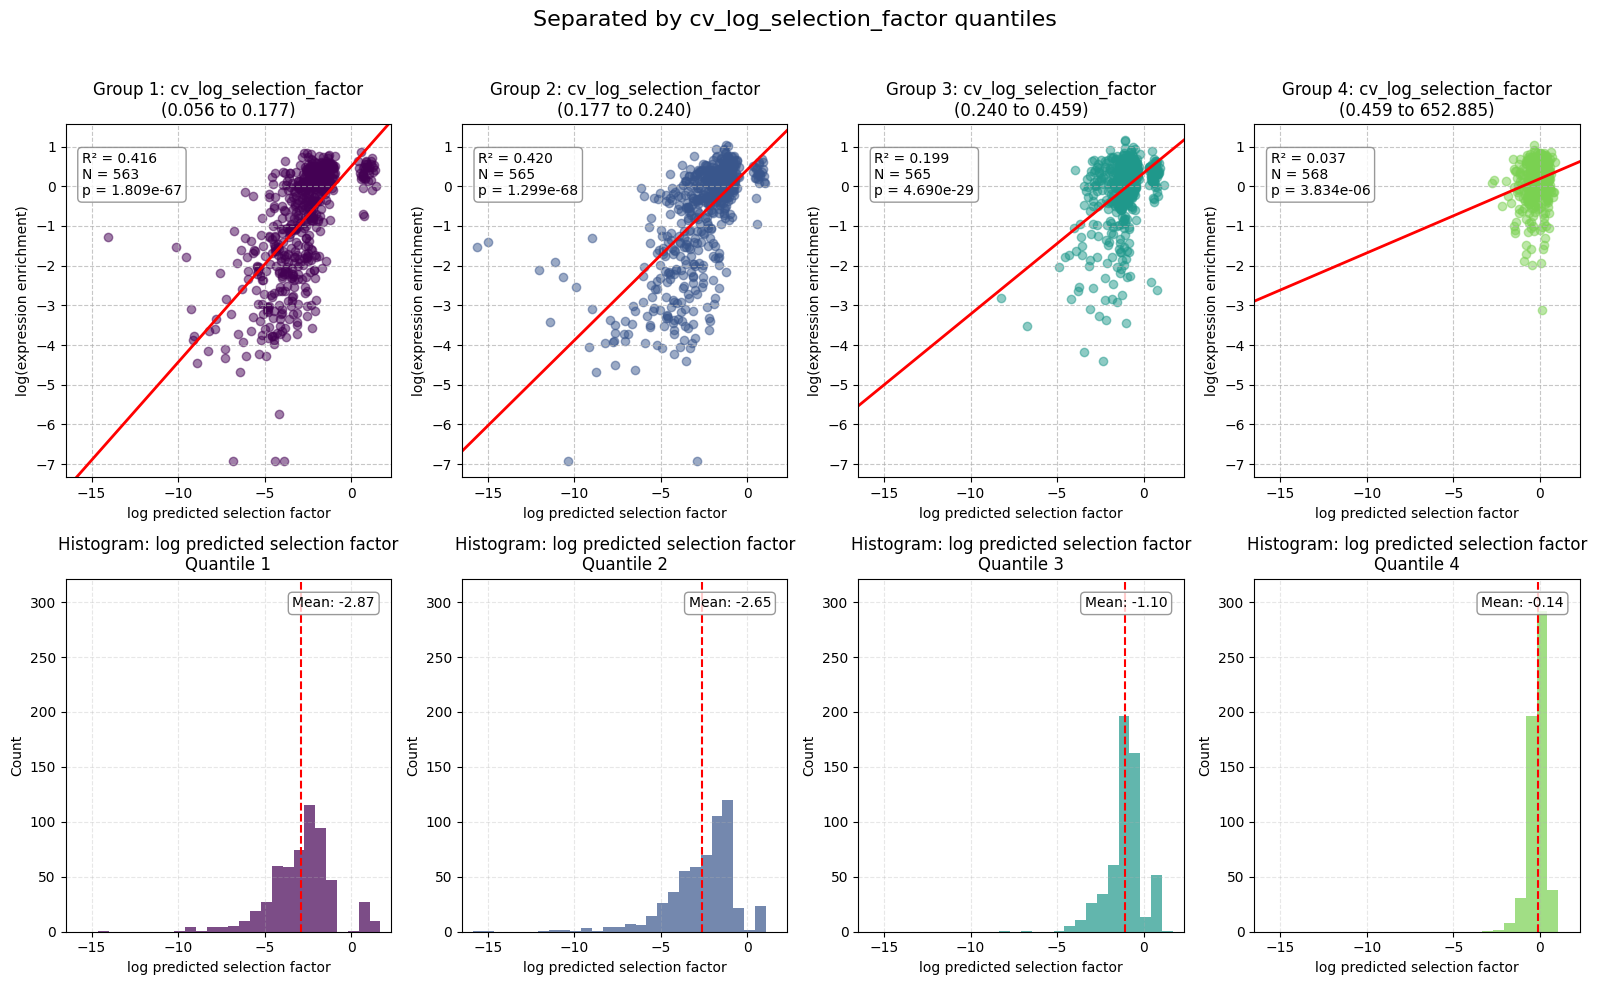

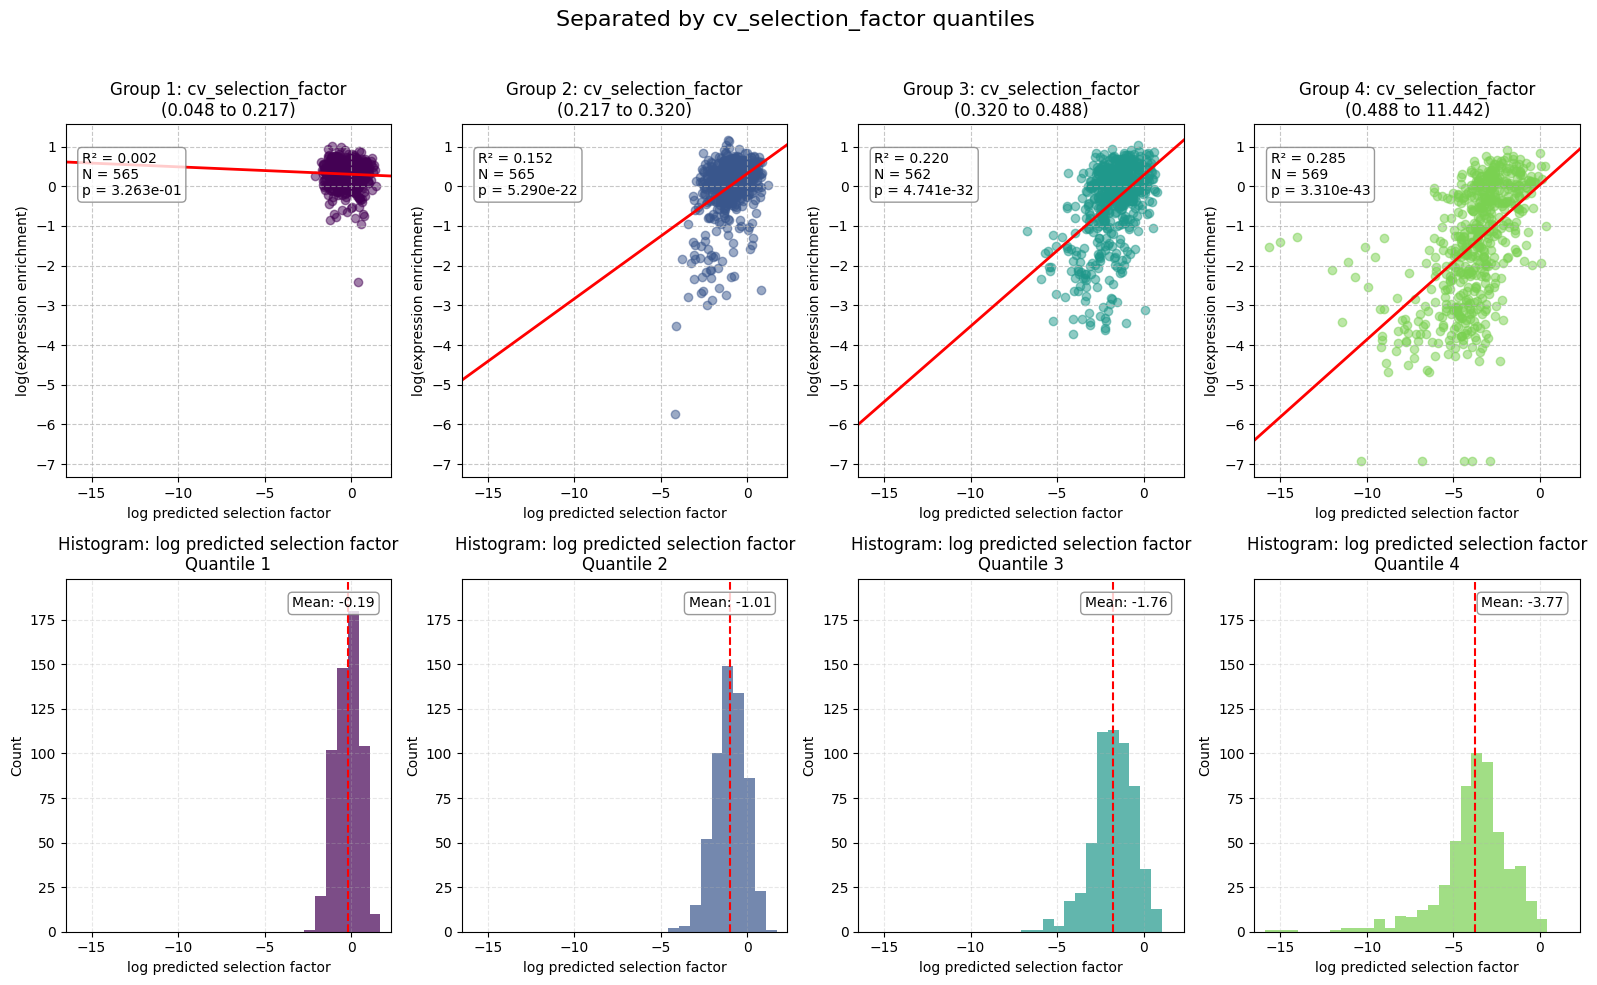

In [30]:
from scipy import stats


def plot_quantile_correlations_with_histograms(df, quantile_col, x_col, y_col, num_quantiles=4, 
                                       figsize=(16, 12), title_prefix='Group', 
                                       x_label=None, y_label=None, hist_label=None,
                                       alpha=0.5, show_grid=True, num_bins=30, return_stats=False):

    # Use default labels if not provided
    if x_label is None:
        x_label = x_col
    if y_label is None:
        y_label = y_col
    if hist_label is None:
        hist_label = x_col
        
    # Calculate quantile boundaries
    quantile_values = [df[quantile_col].quantile(i/num_quantiles) for i in range(num_quantiles+1)]
    
    # Initialize results dictionary if needed
    results = {}
    
    # Create figure with 2 rows x 4 columns (correlations on top, histograms on bottom)
    fig, axes = plt.subplots(2, num_quantiles, figsize=figsize)
    
    # Get the color palette for histograms to match the quantiles
    colors = plt.cm.viridis(np.linspace(0, 0.8, num_quantiles))
    
    # Pre-calculate overall limits for consistent axes
    x_min, x_max = df[x_col].min(), df[x_col].max()
    y_min, y_max = df[y_col].min(), df[y_col].max()
    
    # Add some padding to the limits
    x_range = x_max - x_min
    y_range = y_max - y_min
    x_min -= x_range * 0.05
    x_max += x_range * 0.05
    y_min -= y_range * 0.05
    y_max += y_range * 0.05
    
    # Increased number of bins for histograms
    hist_bins = np.linspace(x_min, x_max, num_bins + 1)  # +1 because linspace includes endpoint
    
    # Find highest histogram bin count for consistent y-axis on histograms
    hist_counts = []
    
    # First pass: collect quantile data and calculate histogram counts
    quantile_datasets = []
    for i in range(num_quantiles):
        lower_bound = quantile_values[i]
        upper_bound = quantile_values[i+1]
        
        # Special case for the last quantile to include the maximum value
        if i == num_quantiles - 1:
            quantile_data = df[(df[quantile_col] >= lower_bound) & (df[quantile_col] <= upper_bound)]
        else:
            quantile_data = df[(df[quantile_col] >= lower_bound) & (df[quantile_col] < upper_bound)]
        
        # Drop NaN values for the columns we're analyzing
        quantile_data = quantile_data.dropna(subset=[x_col, y_col])
        quantile_datasets.append(quantile_data)
        
        # Calculate histogram counts (but don't plot yet)
        if len(quantile_data) > 0:
            counts, _ = np.histogram(quantile_data[x_col], bins=hist_bins)
            hist_counts.append(max(counts))
    
    hist_y_max = max(hist_counts) * 1.1 if hist_counts else 10  # Add 10% padding
    
    # Second pass: create the actual plots with consistent limits
    for i in range(num_quantiles):
        quantile_data = quantile_datasets[i]
        lower_bound = quantile_values[i]
        upper_bound = quantile_values[i+1]
        count = len(quantile_data)
        
        # Calculate statistics for correlation
        if count > 1:  # Need at least 2 points for regression
            slope, intercept, r_value, p_value, std_err = stats.linregress(
                quantile_data[x_col], quantile_data[y_col]
            )
            r_squared = r_value**2
        else:
            slope = intercept = r_value = p_value = std_err = r_squared = np.nan
        
        # Store results if requested
        if return_stats:
            results[f'quantile_{i+1}'] = {
                'range': (lower_bound, upper_bound),
                'count': count,
                'slope': slope,
                'intercept': intercept,
                'r_value': r_value,
                'r_squared': r_squared,
                'p_value': p_value,
                'std_err': std_err
            }
        
        # Get the current axes for this quantile
        ax_corr = axes[0, i]  # Correlation plot (top row)
        ax_hist = axes[1, i]  # Histogram plot (bottom row)
        
        # ---- Create correlation plot (top row) ----
        if count > 1:  # Only plot if we have data points
            # Create scatter plot
            ax_corr.scatter(quantile_data[x_col], quantile_data[y_col], alpha=alpha, color=colors[i])
            
            # Add regression line if we have valid statistics
            if not np.isnan(slope) and not np.isnan(intercept):
                x_range_line = np.linspace(x_min, x_max, 100)
                ax_corr.plot(x_range_line, intercept + slope*x_range_line, 'r', linewidth=2)
            
            # Add R² annotation
            ax_corr.annotate(
                f"R² = {r_squared:.3f}\nN = {count}\np = {p_value:.3e}", 
                xy=(0.05, 0.8), 
                xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
            )
        else:
            ax_corr.text(0.5, 0.5, f"Insufficient data (N={count})", 
                   ha='center', va='center', transform=ax_corr.transAxes)
        
        # Set the same limits for all correlation plots
        ax_corr.set_xlim(x_min, x_max)
        ax_corr.set_ylim(y_min, y_max)
        
        # ---- Create histogram plot (bottom row) ----
        if count > 0:  # Only plot if we have data
            # Plot histogram of x_col values with more bins and consistent bins
            ax_hist.hist(quantile_data[x_col], bins=hist_bins, alpha=0.7, color=colors[i])
            ax_hist.set_title(f'Histogram: {hist_label}\nQuantile {i+1}')
            ax_hist.set_xlabel(hist_label)
            ax_hist.set_ylabel('Count')
            
            # Set consistent y-axis limit for histograms
            ax_hist.set_ylim(0, hist_y_max)
            
            # Set consistent x-axis limit for histograms (same as correlation plots)
            ax_hist.set_xlim(x_min, x_max)
            
            # Add vertical line for mean
            mean_val = quantile_data[x_col].mean()
            ax_hist.axvline(mean_val, color='r', linestyle='--', linewidth=1.5)
            ax_hist.text(0.95, 0.95, f'Mean: {mean_val:.2f}', 
                         transform=ax_hist.transAxes, 
                         horizontalalignment='right',
                         verticalalignment='top',
                         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
        else:
            ax_hist.text(0.5, 0.5, f"No data (N={count})", 
                   ha='center', va='center', transform=ax_hist.transAxes)
            # Still set consistent limits even for empty plots
            ax_hist.set_xlim(x_min, x_max)
            ax_hist.set_ylim(0, hist_y_max)
        
        # Set labels and title for correlation plot
        quantile_range_text = f"{lower_bound:.3f} to {upper_bound:.3f}"
        ax_corr.set_xlabel(x_label)
        ax_corr.set_ylabel(y_label)
        ax_corr.set_title(f'{title_prefix} {i+1}: {quantile_col}\n({quantile_range_text})')
        
        if show_grid:
            ax_corr.grid(True, linestyle='--', alpha=0.7)
            ax_hist.grid(True, linestyle='--', alpha=0.3)
    
    # Add a main title for the entire figure
    plt.suptitle(f'Separated by {quantile_col} quantiles', 
                 fontsize=16, y=0.98)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave room for the suptitle
    plt.show()
    
    if return_stats:
        return results

# Example usage
for stat_measure in ['normalized_ci_log_selection_factor', 'normalized_ci_selection_factor', 
                     'cv_log_selection_factor', 'cv_selection_factor']:
    plot_quantile_correlations_with_histograms(
        df=stats_predict_df,
        quantile_col=stat_measure,
        x_col='DASM_log_selection_factor',
        y_col='Expression_log',
        num_quantiles=4,
        x_label='log predicted selection factor',
        y_label='log(expression enrichment)',
        hist_label='log predicted selection factor',
        figsize=(16, 10),
        num_bins=30  # Increased number of bins for more detailed histograms
    )

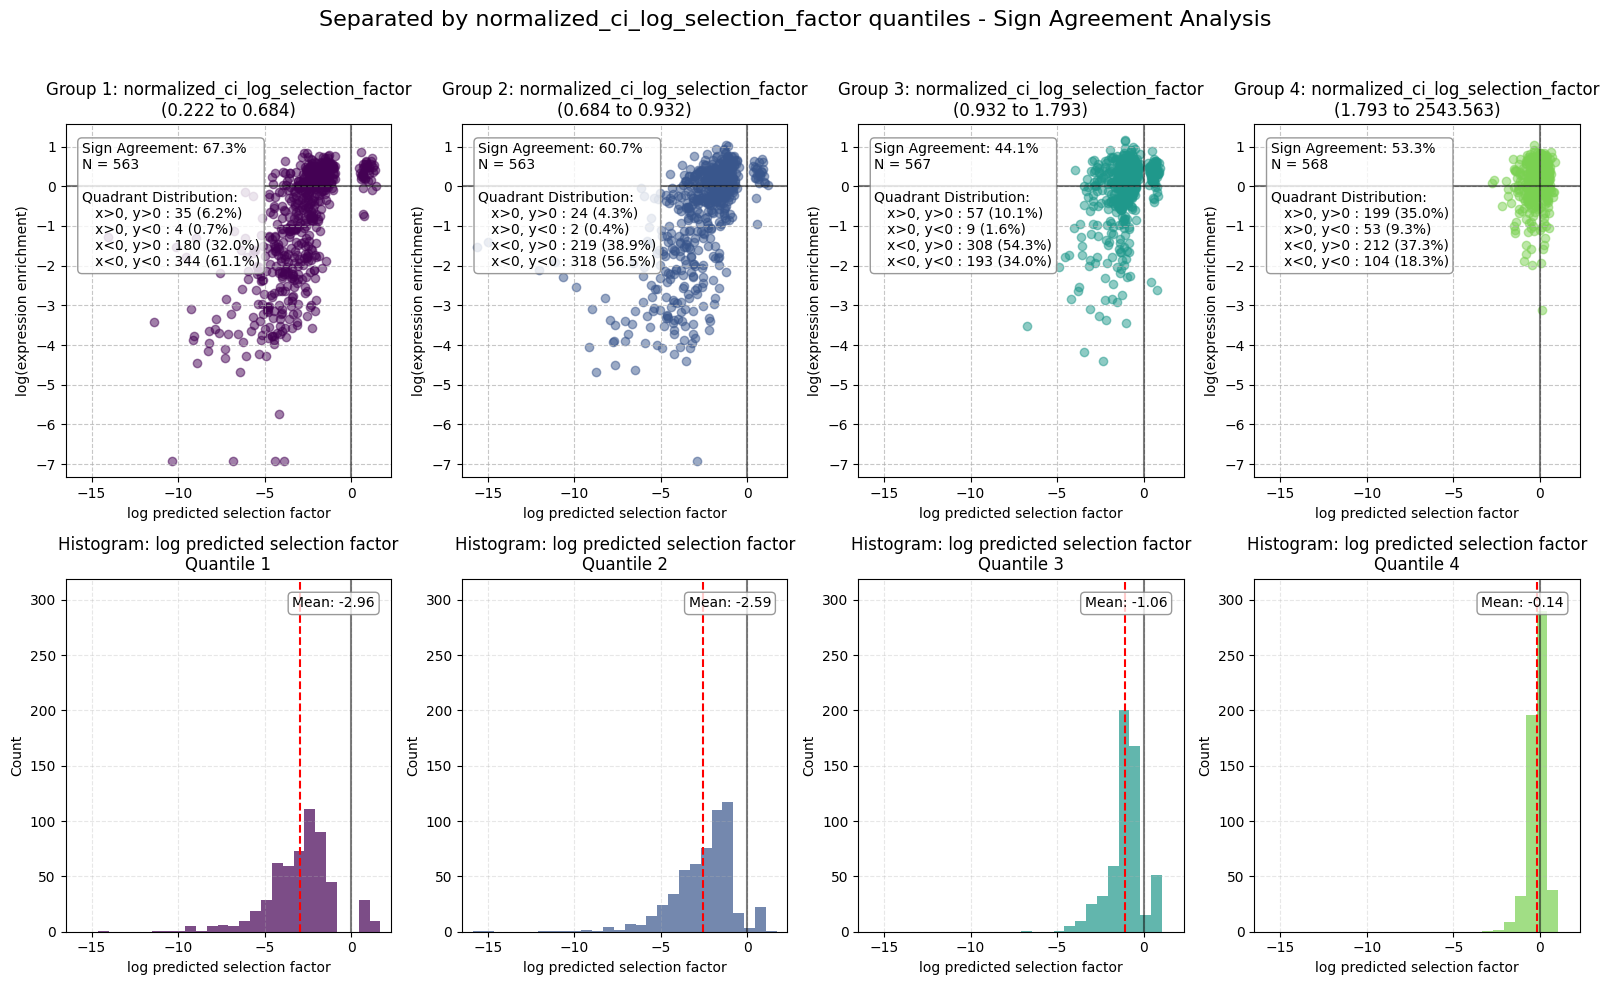

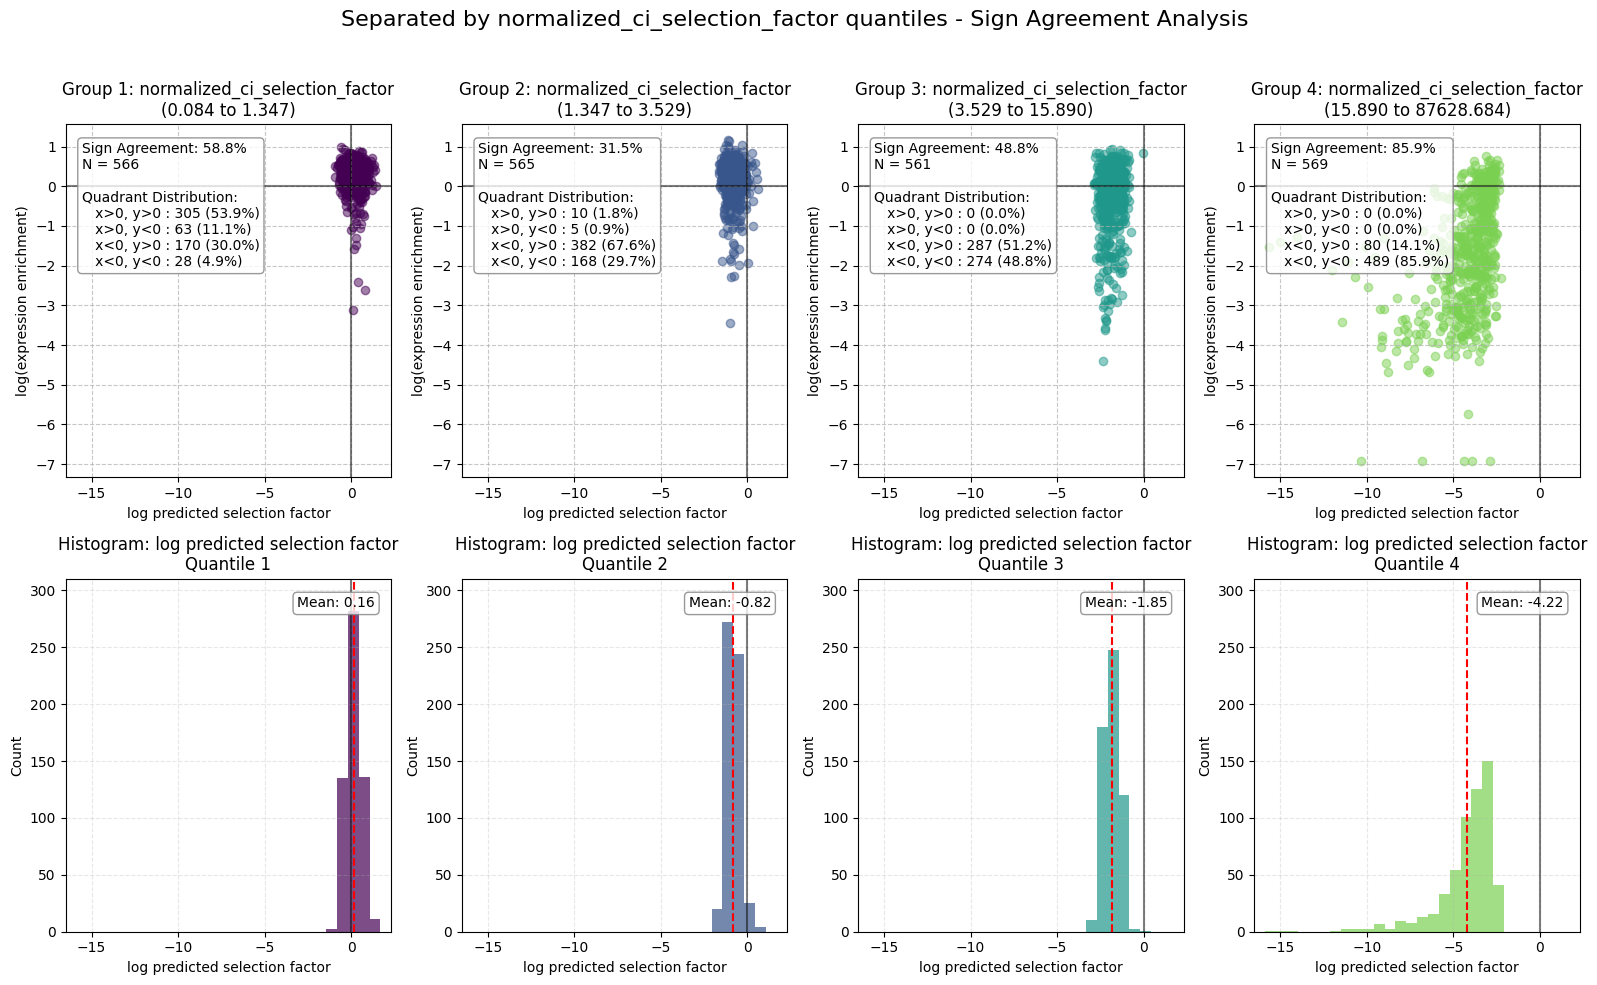

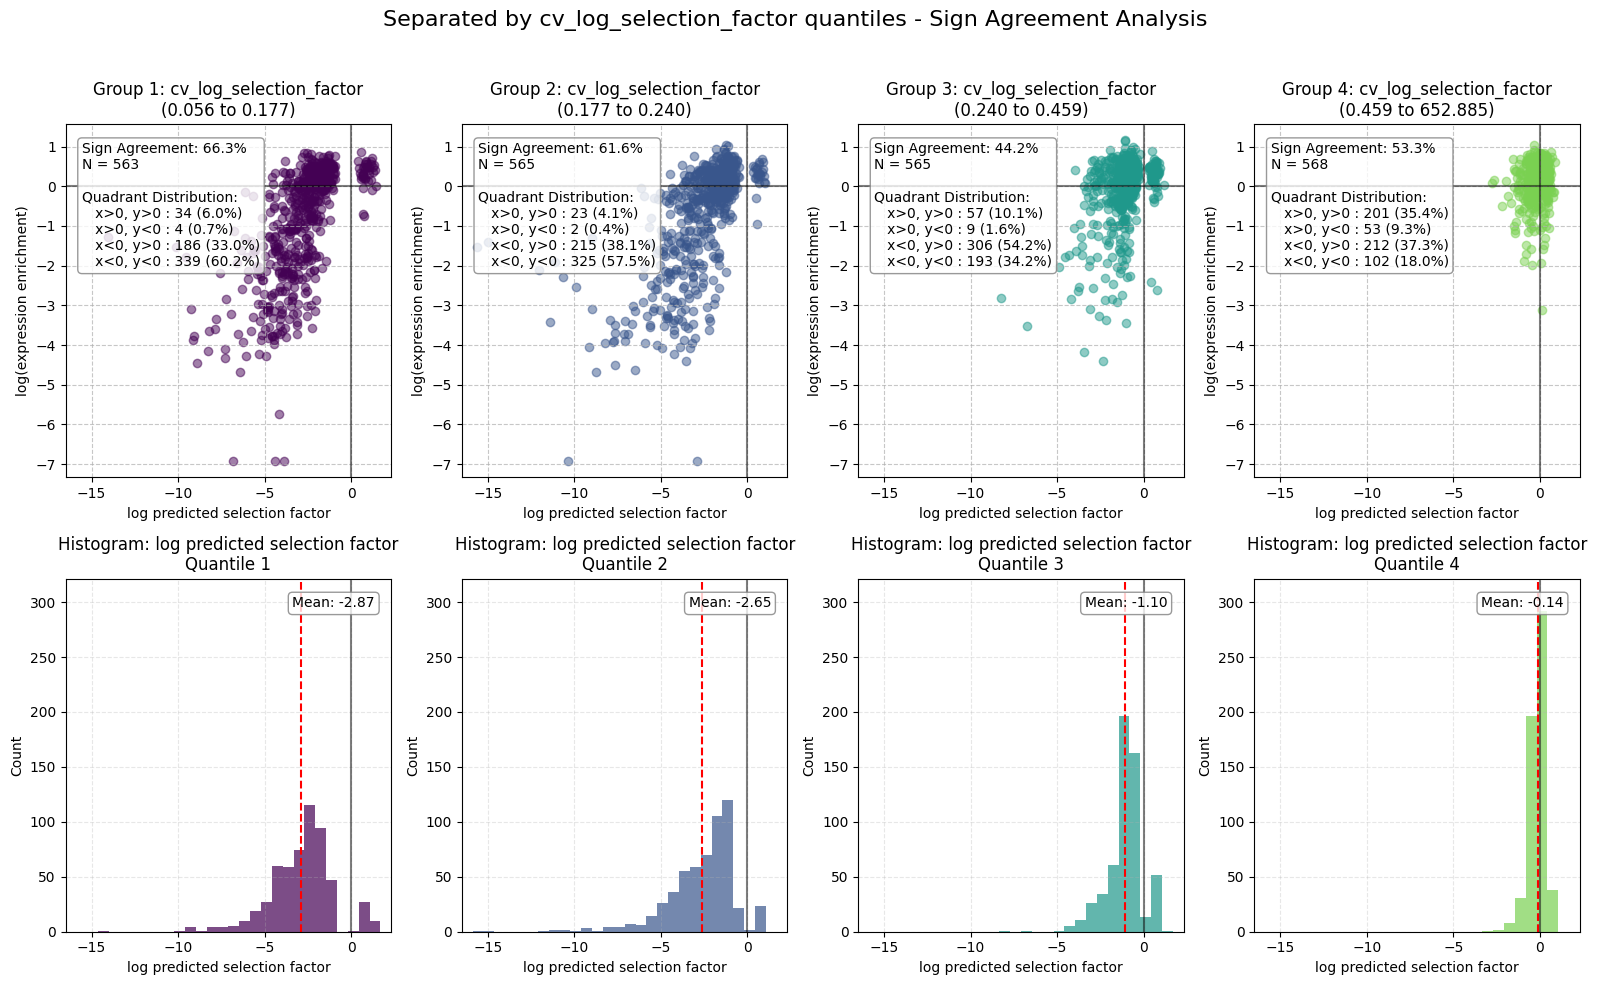

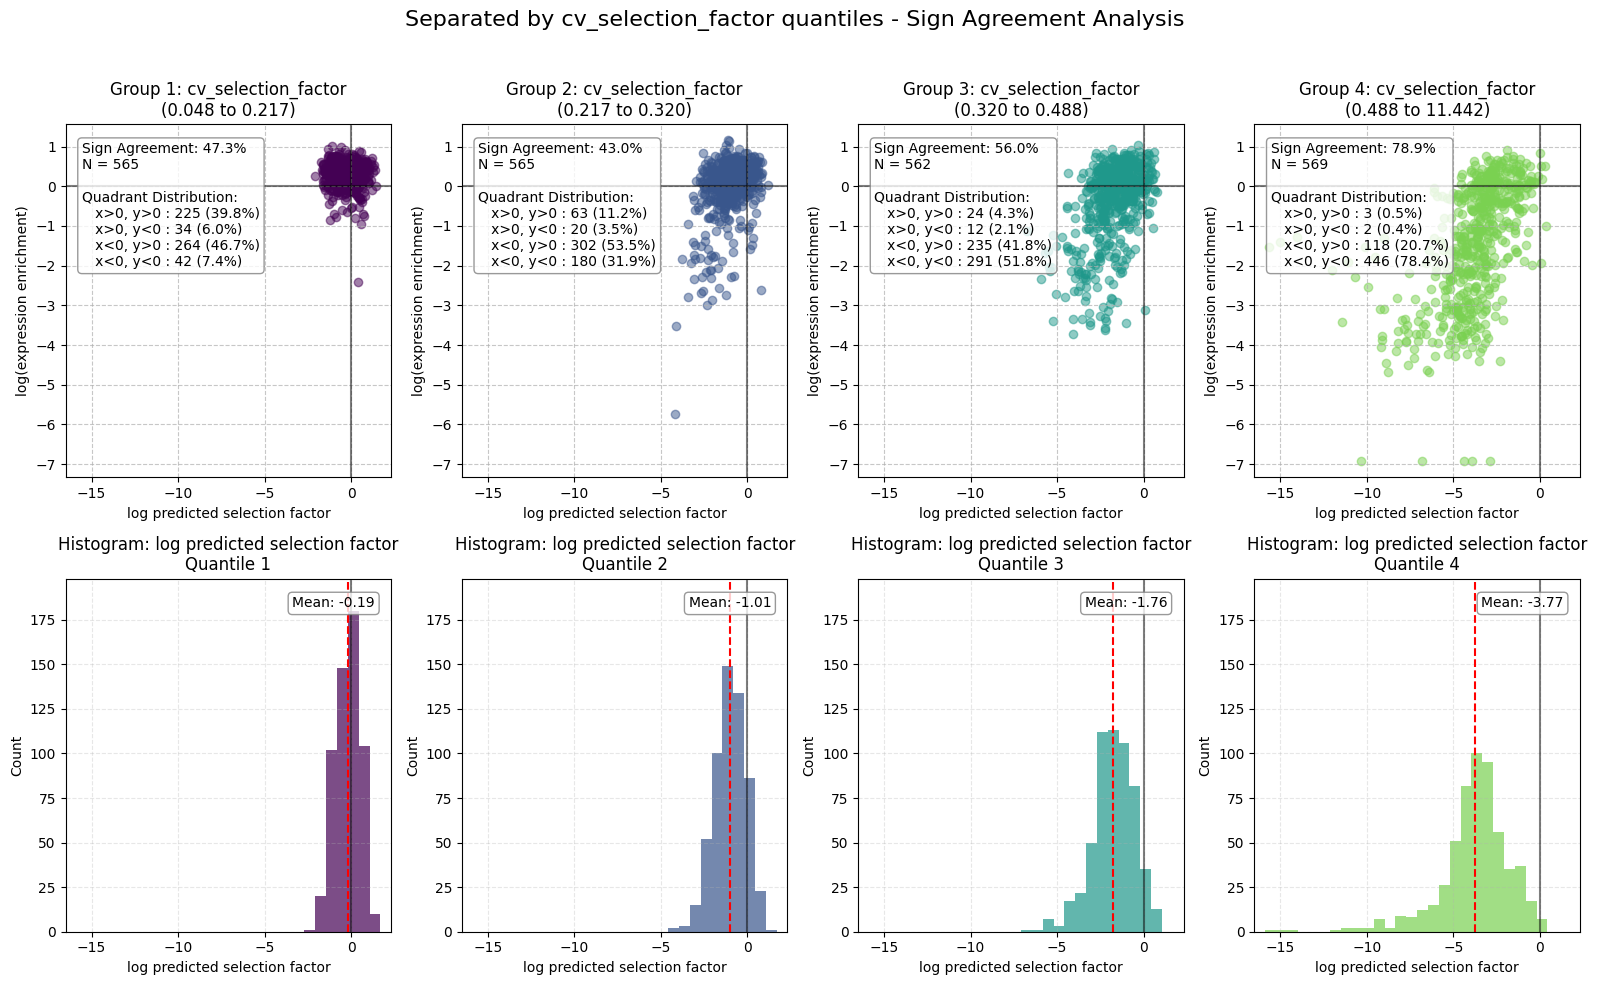

In [31]:
from scipy import stats


def plot_quantile_correlations_with_contingency(df, quantile_col, x_col, y_col, num_quantiles=4, 
                                       figsize=(16, 12), title_prefix='Group', 
                                       x_label=None, y_label=None, hist_label=None,
                                       alpha=0.5, show_grid=True, num_bins=30, return_stats=False):

    # Use default labels if not provided
    if x_label is None:
        x_label = x_col
    if y_label is None:
        y_label = y_col
    if hist_label is None:
        hist_label = x_col
        
    # Calculate quantile boundaries
    quantile_values = [df[quantile_col].quantile(i/num_quantiles) for i in range(num_quantiles+1)]
    
    # Initialize results dictionary if needed
    results = {}
    
    # Create figure with 2 rows x 4 columns (correlations on top, histograms on bottom)
    fig, axes = plt.subplots(2, num_quantiles, figsize=figsize)
    
    # Get the color palette for histograms to match the quantiles
    colors = plt.cm.viridis(np.linspace(0, 0.8, num_quantiles))
    
    # Pre-calculate overall limits for consistent axes
    x_min, x_max = df[x_col].min(), df[x_col].max()
    y_min, y_max = df[y_col].min(), df[y_col].max()
    
    # Add some padding to the limits
    x_range = x_max - x_min
    y_range = y_max - y_min
    x_min -= x_range * 0.05
    x_max += x_range * 0.05
    y_min -= y_range * 0.05
    y_max += y_range * 0.05
    
    # Increased number of bins for histograms
    hist_bins = np.linspace(x_min, x_max, num_bins + 1)
    
    # Find highest histogram bin count for consistent y-axis on histograms
    hist_counts = []
    
    # First pass: collect quantile data and calculate histogram counts
    quantile_datasets = []
    for i in range(num_quantiles):
        lower_bound = quantile_values[i]
        upper_bound = quantile_values[i+1]
        
        # Special case for the last quantile to include the maximum value
        if i == num_quantiles - 1:
            quantile_data = df[(df[quantile_col] >= lower_bound) & (df[quantile_col] <= upper_bound)]
        else:
            quantile_data = df[(df[quantile_col] >= lower_bound) & (df[quantile_col] < upper_bound)]
        
        # Drop NaN values for the columns we're analyzing
        quantile_data = quantile_data.dropna(subset=[x_col, y_col])
        quantile_datasets.append(quantile_data)
        
        # Calculate histogram counts (but don't plot yet)
        if len(quantile_data) > 0:
            counts, _ = np.histogram(quantile_data[x_col], bins=hist_bins)
            hist_counts.append(max(counts))
    
    hist_y_max = max(hist_counts) * 1.1 if hist_counts else 10  # Add 10% padding
    
    # Second pass: create the actual plots with consistent limits
    for i in range(num_quantiles):
        quantile_data = quantile_datasets[i]
        lower_bound = quantile_values[i]
        upper_bound = quantile_values[i+1]
        count = len(quantile_data)
        
        # Get the current axes for this quantile
        ax_corr = axes[0, i]  # Correlation plot (top row)
        ax_hist = axes[1, i]  # Histogram plot (bottom row)
        
        # ---- Create correlation plot (top row) ----
        if count > 1:  # Only plot if we have data points
            # Create scatter plot
            ax_corr.scatter(quantile_data[x_col], quantile_data[y_col], alpha=alpha, color=colors[i])
            
            # Add horizontal and vertical lines at y=0 and x=0
            ax_corr.axhline(y=0, color='black', linestyle='-', alpha=0.5)
            ax_corr.axvline(x=0, color='black', linestyle='-', alpha=0.5)
            
            # Create 2x2 contingency table for sign agreement
            x_pos = quantile_data[x_col] > 0
            y_pos = quantile_data[y_col] > 0
            
            # Count points in each quadrant
            top_right = sum(x_pos & y_pos)         # Both positive
            bottom_right = sum(x_pos & ~y_pos)     # x positive, y negative
            top_left = sum(~x_pos & y_pos)         # x negative, y positive
            bottom_left = sum(~x_pos & ~y_pos)     # Both negative
            
            # Calculate sign agreement percentage
            sign_agreement = (top_right + bottom_left) / count * 100
            
            # Create table text for annotation
            table_text = (
                f"Sign Agreement: {sign_agreement:.1f}%\n"
                f"N = {count}\n\n"
                f"Quadrant Distribution:\n"
                f"   x>0, y>0 : {top_right} ({top_right/count*100:.1f}%)\n"
                f"   x>0, y<0 : {bottom_right} ({bottom_right/count*100:.1f}%)\n"
                f"   x<0, y>0 : {top_left} ({top_left/count*100:.1f}%)\n"
                f"   x<0, y<0 : {bottom_left} ({bottom_left/count*100:.1f}%)"
            )
            
            # Add contingency table as annotation
            ax_corr.annotate(
                table_text, 
                xy=(0.05, 0.95), 
                xycoords='axes fraction',
                verticalalignment='top',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
            )
            
            # Store results if requested
            if return_stats:
                results[f'quantile_{i+1}'] = {
                    'range': (lower_bound, upper_bound),
                    'count': count,
                    'sign_agreement_percent': sign_agreement,
                    'quadrants': {
                        'both_positive': top_right,
                        'x_pos_y_neg': bottom_right,
                        'x_neg_y_pos': top_left,
                        'both_negative': bottom_left
                    }
                }
        else:
            ax_corr.text(0.5, 0.5, f"Insufficient data (N={count})", 
                   ha='center', va='center', transform=ax_corr.transAxes)
        
        # Set the same limits for all correlation plots
        ax_corr.set_xlim(x_min, x_max)
        ax_corr.set_ylim(y_min, y_max)
        
        # ---- Create histogram plot (bottom row) ----
        if count > 0:  # Only plot if we have data
            # Plot histogram of x_col values with more bins and consistent bins
            ax_hist.hist(quantile_data[x_col], bins=hist_bins, alpha=0.7, color=colors[i])
            ax_hist.set_title(f'Histogram: {hist_label}\nQuantile {i+1}')
            ax_hist.set_xlabel(hist_label)
            ax_hist.set_ylabel('Count')
            
            # Set consistent y-axis limit for histograms
            ax_hist.set_ylim(0, hist_y_max)
            
            # Set consistent x-axis limit for histograms (same as correlation plots)
            ax_hist.set_xlim(x_min, x_max)
            
            # Add vertical lines for mean and zero
            mean_val = quantile_data[x_col].mean()
            ax_hist.axvline(mean_val, color='r', linestyle='--', linewidth=1.5)
            ax_hist.axvline(0, color='black', linestyle='-', alpha=0.5)
            
            # Add mean annotation
            ax_hist.text(0.95, 0.95, f'Mean: {mean_val:.2f}', 
                         transform=ax_hist.transAxes, 
                         horizontalalignment='right',
                         verticalalignment='top',
                         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
        else:
            ax_hist.text(0.5, 0.5, f"No data (N={count})", 
                   ha='center', va='center', transform=ax_hist.transAxes)
            # Still set consistent limits even for empty plots
            ax_hist.set_xlim(x_min, x_max)
            ax_hist.set_ylim(0, hist_y_max)
        
        # Set labels and title for correlation plot
        quantile_range_text = f"{lower_bound:.3f} to {upper_bound:.3f}"
        ax_corr.set_xlabel(x_label)
        ax_corr.set_ylabel(y_label)
        ax_corr.set_title(f'{title_prefix} {i+1}: {quantile_col}\n({quantile_range_text})')
        
        if show_grid:
            ax_corr.grid(True, linestyle='--', alpha=0.7)
            ax_hist.grid(True, linestyle='--', alpha=0.3)
    
    # Add a main title for the entire figure
    plt.suptitle(f'Separated by {quantile_col} quantiles - Sign Agreement Analysis', 
                 fontsize=16, y=0.98)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave room for the suptitle
    plt.show()
    
    if return_stats:
        return results
    
for stat_measure in ['normalized_ci_log_selection_factor', 'normalized_ci_selection_factor', 
                     'cv_log_selection_factor', 'cv_selection_factor']:
    plot_quantile_correlations_with_contingency(
        df=stats_predict_df,
        quantile_col=stat_measure,
        x_col='DASM_log_selection_factor',
        y_col='Expression_log',
        num_quantiles=4,
        x_label='log predicted selection factor',
        y_label='log(expression enrichment)',
        hist_label='log predicted selection factor',
        figsize=(16, 10),
        num_bins=30  # Increased number of bins for more detailed histograms
    )

### Normalized CI on log data and coefficient of variation on log data does seem to separate the data into better and worse predictions (q1 r^2 is much better thean q4 r^2)
### We seem to not have a lot of confidence for the selection factors that are -0.5 < p > 0.5. Does this make sense or is this just an artifact of the uncertainty calculation as we are dividing by the mean prediction?
### Let's look at the data qunatiled by the prediction itself


Analysis with 4 quantiles:


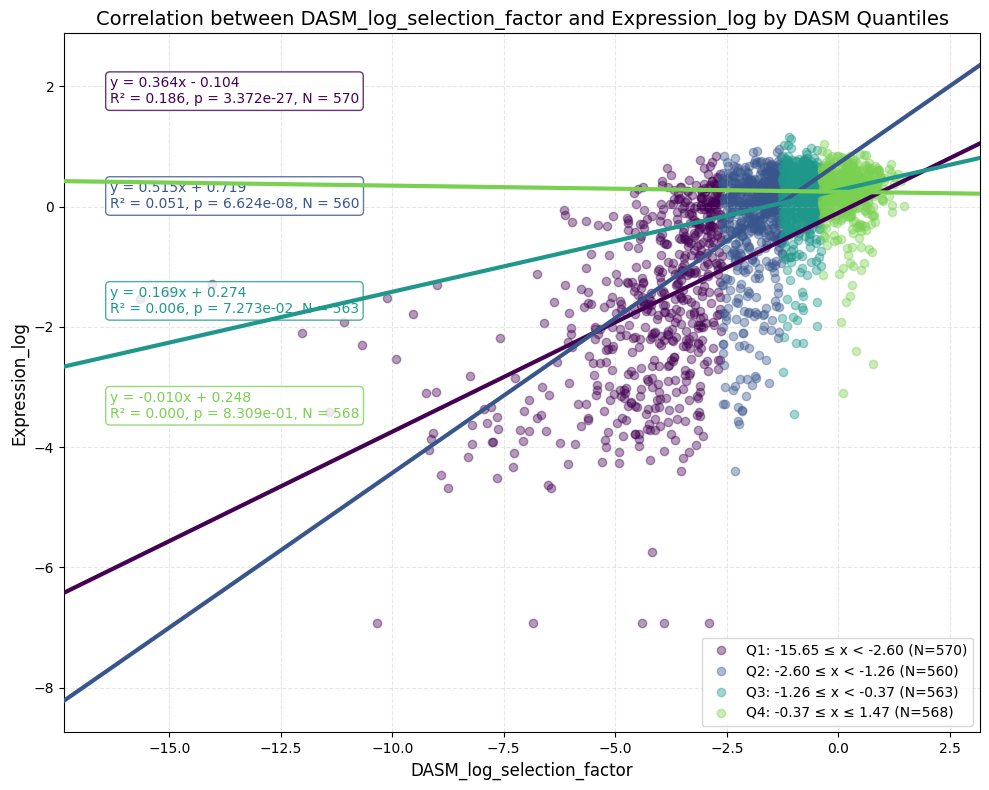


Detailed regression statistics:
Quantile 1:
  Range: -15.647 to -2.604
  N: 570
  R²: 0.186
  p-value: 3.372e-27
  Equation: y = 0.364x + -0.104

Quantile 2:
  Range: -2.604 to -1.265
  N: 560
  R²: 0.051
  p-value: 6.624e-08
  Equation: y = 0.515x + 0.719

Quantile 3:
  Range: -1.265 to -0.370
  N: 563
  R²: 0.006
  p-value: 7.273e-02
  Equation: y = 0.169x + 0.274

Quantile 4:
  Range: -0.370 to 1.465
  N: 568
  R²: 0.000
  p-value: 8.309e-01
  Equation: y = -0.010x + 0.248



In [32]:
from scipy import stats


def plot_combined_dasm_quantiles(df, x_col, y_col, num_quantiles=4, 
                              figsize=(12, 8), alpha=0.5, show_grid=True):
    """
    Creates a single plot with data points and regression lines for different DASM quantiles,
    each with its own color. Regression lines are extended beyond data points and drawn on top.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The dataframe containing all the data
    x_col : str
        Column name for x-axis values
    y_col : str
        Column name for y-axis values
    num_quantiles : int
        Number of quantiles to divide the data into
    figsize : tuple
        Figure size (width, height) in inches
    alpha : float
        Transparency of scatter points
    show_grid : bool
        Whether to show grid lines in plot
    """ 
    ## not sure why this is needed, but need to reimport this every time
    from scipy import stats


    # Create figure
    plt.figure(figsize=figsize)
    
    # Get colors for different DASM quantiles
    colors = plt.cm.viridis(np.linspace(0, 0.8, num_quantiles))
    
    # Store regression info for return value
    regression_info = []
    
    # Calculate quantile boundaries
    quantile_values = [df[x_col].quantile(i/num_quantiles) for i in range(num_quantiles+1)]
    
    # First get the overall min/max for x-axis for more consistent regression lines
    overall_x_min = df[x_col].min()
    overall_x_max = df[x_col].max()
    x_range_total = overall_x_max - overall_x_min
    extended_x_min = overall_x_min - x_range_total * 0.1  # Extend by 10% on each side
    extended_x_max = overall_x_max + x_range_total * 0.1
    
    # First pass: Plot all scatter points
    for idx in range(num_quantiles):
        # Get the quantile boundaries
        lower_bound = quantile_values[idx]
        upper_bound = quantile_values[idx+1]
        
        # Special case for the last quantile to include the maximum value
        if idx == num_quantiles - 1:
            quantile_mask = (df[x_col] >= lower_bound) & (df[x_col] <= upper_bound)
            quantile_label = f"Q{idx+1}: {lower_bound:.2f} ≤ x ≤ {upper_bound:.2f}"
        else:
            quantile_mask = (df[x_col] >= lower_bound) & (df[x_col] < upper_bound)
            quantile_label = f"Q{idx+1}: {lower_bound:.2f} ≤ x < {upper_bound:.2f}"
        
        # Get data for this quantile
        quantile_data = df[quantile_mask].dropna(subset=[x_col, y_col])
        count = len(quantile_data)
        
        if count > 1:  # Need at least 2 points for regression
            # Create scatter plot
            plt.scatter(quantile_data[x_col], quantile_data[y_col], 
                      alpha=alpha, color=colors[idx], label=f"{quantile_label} (N={count})")
    
    # Second pass: Calculate and plot regression lines on top of all points
    for idx in range(num_quantiles):
        # Get the quantile boundaries
        lower_bound = quantile_values[idx]
        upper_bound = quantile_values[idx+1]
        
        # Special case for the last quantile to include the maximum value
        if idx == num_quantiles - 1:
            quantile_mask = (df[x_col] >= lower_bound) & (df[x_col] <= upper_bound)
            quantile_label = f"Q{idx+1}: {lower_bound:.2f} ≤ x ≤ {upper_bound:.2f}"
        else:
            quantile_mask = (df[x_col] >= lower_bound) & (df[x_col] < upper_bound)
            quantile_label = f"Q{idx+1}: {lower_bound:.2f} ≤ x < {upper_bound:.2f}"
        
        # Get data for this quantile
        quantile_data = df[quantile_mask].dropna(subset=[x_col, y_col])
        count = len(quantile_data)
        
        # Create correlation plot
        if count > 1:  # Need at least 2 points for regression
            # Calculate regression
            slope, intercept, r_value, p_value, std_err = stats.linregress(
                quantile_data[x_col], quantile_data[y_col]
            )
            r_squared = r_value**2
            
            # Use extended x range for regression line to make it longer
            x_range_line = np.linspace(extended_x_min, extended_x_max, 200)
            plt.plot(x_range_line, intercept + slope*x_range_line, '-', 
                   color=colors[idx], linewidth=3, zorder=10)  # Higher zorder to ensure line is on top
            
            # Format the regression equation
            sign = "+" if intercept >= 0 else "-"
            equation = f"y = {slope:.3f}x {sign} {abs(intercept):.3f}"
            stats_text = f"R² = {r_squared:.3f}, p = {p_value:.3e}, N = {count}"
            
            # Adjust position for each range to avoid overlap
            y_pos = 0.90 - (idx * 0.15)
            plt.annotate(f"{equation}\n{stats_text}",
                       xy=(0.05, y_pos), xycoords='axes fraction',
                       color=colors[idx],
                       bbox=dict(boxstyle="round,pad=0.3", fc="white", ec=colors[idx], alpha=0.8),
                       fontsize=10)
            
            # Store regression info
            regression_info.append({
                'quantile': idx+1,
                'range': (lower_bound, upper_bound),
                'n': count,
                'r_squared': r_squared,
                'p_value': p_value,
                'slope': slope,
                'intercept': intercept
            })
        else:
            print(f"Insufficient data (N={count}) for DASM quantile {idx+1}")
    
    # Set limits to show extended regression lines
    plt.xlim(extended_x_min, extended_x_max)
    
    # Set labels and title
    plt.xlabel(x_col, fontsize=12)
    plt.ylabel(y_col, fontsize=12)
    plt.title(f'Correlation between {x_col} and {y_col} by DASM Quantiles', fontsize=14)
    
    # Add grid if requested
    if show_grid:
        plt.grid(True, linestyle='--', alpha=0.3)
    
    # Add legend
    plt.legend(loc='lower right', fontsize=10)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    
    return regression_info

# Plot with different numbers of quantiles
for num_q in [4]:
    print(f"\nAnalysis with {num_q} quantiles:")
    regression_stats = plot_combined_dasm_quantiles(
        df=stats_predict_df, 
        x_col='DASM_log_selection_factor',
        y_col='Expression_log',
        num_quantiles=num_q,
        figsize=(10, 8),
        alpha=0.4
    )
    
    # Print detailed regression statistics
    print("\nDetailed regression statistics:")
    for stats in regression_stats:
        print(f"Quantile {stats['quantile']}:")
        print(f"  Range: {stats['range'][0]:.3f} to {stats['range'][1]:.3f}")
        print(f"  N: {stats['n']}")
        print(f"  R²: {stats['r_squared']:.3f}")
        print(f"  p-value: {stats['p_value']:.3e}")
        print(f"  Equation: y = {stats['slope']:.3f}x + {stats['intercept']:.3f}")
        print()


Analysis with 4 quantiles:


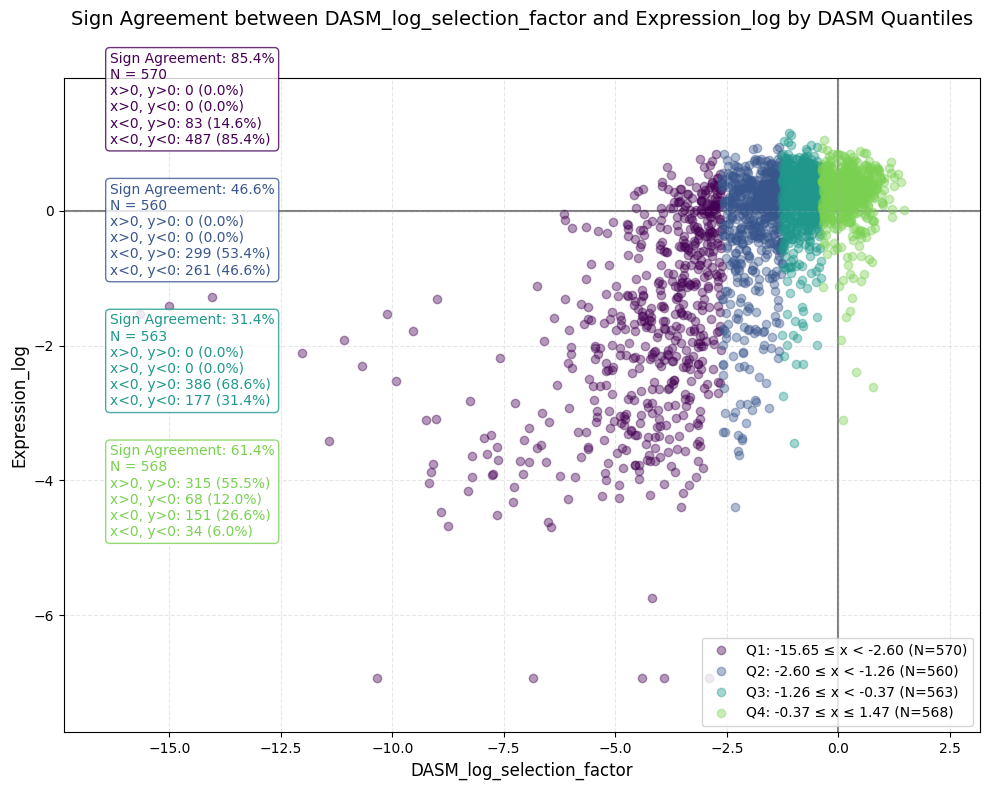


Detailed sign agreement statistics:
Quantile 1:
  Range: -15.647 to -2.604
  N: 570
  Sign Agreement: 85.4%
  Quadrant Distribution:
    Both positive: 0 (0.0%)
    x>0, y<0: 0 (0.0%)
    x<0, y>0: 83 (14.6%)
    Both negative: 487 (85.4%)

Quantile 2:
  Range: -2.604 to -1.265
  N: 560
  Sign Agreement: 46.6%
  Quadrant Distribution:
    Both positive: 0 (0.0%)
    x>0, y<0: 0 (0.0%)
    x<0, y>0: 299 (53.4%)
    Both negative: 261 (46.6%)

Quantile 3:
  Range: -1.265 to -0.370
  N: 563
  Sign Agreement: 31.4%
  Quadrant Distribution:
    Both positive: 0 (0.0%)
    x>0, y<0: 0 (0.0%)
    x<0, y>0: 386 (68.6%)
    Both negative: 177 (31.4%)

Quantile 4:
  Range: -0.370 to 1.465
  N: 568
  Sign Agreement: 61.4%
  Quadrant Distribution:
    Both positive: 315 (55.5%)
    x>0, y<0: 68 (12.0%)
    x<0, y>0: 151 (26.6%)
    Both negative: 34 (6.0%)



In [33]:
from scipy import stats


def plot_combined_dasm_quantiles(df, x_col, y_col, num_quantiles=4, 
                              figsize=(12, 8), alpha=0.5, show_grid=True):
    """
    Creates a single plot with data points for different DASM quantiles,
    each with its own color. Instead of regression lines, analyzes sign agreement
    between variables.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The dataframe containing all the data
    x_col : str
        Column name for x-axis values
    y_col : str
        Column name for y-axis values
    num_quantiles : int
        Number of quantiles to divide the data into
    figsize : tuple
        Figure size (width, height) in inches
    alpha : float
        Transparency of scatter points
    show_grid : bool
        Whether to show grid lines in plot
    """
    # Create figure
    plt.figure(figsize=figsize)
    
    # Get colors for different DASM quantiles
    colors = plt.cm.viridis(np.linspace(0, 0.8, num_quantiles))
    
    # Store sign agreement info for return value
    sign_agreement_info = []
    
    # Calculate quantile boundaries
    quantile_values = [df[x_col].quantile(i/num_quantiles) for i in range(num_quantiles+1)]
    
    # Get overall min/max for consistent plotting
    overall_x_min = df[x_col].min()
    overall_x_max = df[x_col].max()
    overall_y_min = df[y_col].min()
    overall_y_max = df[y_col].max()
    
    x_range_total = overall_x_max - overall_x_min
    y_range_total = overall_y_max - overall_y_min
    
    extended_x_min = overall_x_min - x_range_total * 0.1
    extended_x_max = overall_x_max + x_range_total * 0.1
    extended_y_min = overall_y_min - y_range_total * 0.1
    extended_y_max = overall_y_max + y_range_total * 0.1
    
    # Plot reference lines at x=0 and y=0
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, zorder=0)
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.5, zorder=0)
    
    # First pass: Plot all scatter points and calculate sign agreement
    for idx in range(num_quantiles):
        # Get the quantile boundaries
        lower_bound = quantile_values[idx]
        upper_bound = quantile_values[idx+1]
        
        # Special case for the last quantile to include the maximum value
        if idx == num_quantiles - 1:
            quantile_mask = (df[x_col] >= lower_bound) & (df[x_col] <= upper_bound)
            quantile_label = f"Q{idx+1}: {lower_bound:.2f} ≤ x ≤ {upper_bound:.2f}"
        else:
            quantile_mask = (df[x_col] >= lower_bound) & (df[x_col] < upper_bound)
            quantile_label = f"Q{idx+1}: {lower_bound:.2f} ≤ x < {upper_bound:.2f}"
        
        # Get data for this quantile
        quantile_data = df[quantile_mask].dropna(subset=[x_col, y_col])
        count = len(quantile_data)
        
        if count > 1:
            # Create scatter plot
            plt.scatter(quantile_data[x_col], quantile_data[y_col], 
                      alpha=alpha, color=colors[idx], label=f"{quantile_label} (N={count})")
            
            # Compute sign agreement
            x_pos = quantile_data[x_col] > 0
            y_pos = quantile_data[y_col] > 0
            
            # Count points in each quadrant
            top_right = sum(x_pos & y_pos)         # Both positive
            bottom_right = sum(x_pos & ~y_pos)     # x positive, y negative
            top_left = sum(~x_pos & y_pos)         # x negative, y positive
            bottom_left = sum(~x_pos & ~y_pos)     # Both negative
            
            # Calculate sign agreement percentage
            sign_agreement = (top_right + bottom_left) / count * 100
            
            # Adjust position for each range to avoid overlap
            y_pos = 0.90 - (idx * 0.20)
            
            # Format the contingency table text
            table_text = (
                f"Sign Agreement: {sign_agreement:.1f}%\n"
                f"N = {count}\n"
                f"x>0, y>0: {top_right} ({top_right/count*100:.1f}%)\n"
                f"x>0, y<0: {bottom_right} ({bottom_right/count*100:.1f}%)\n"
                f"x<0, y>0: {top_left} ({top_left/count*100:.1f}%)\n"
                f"x<0, y<0: {bottom_left} ({bottom_left/count*100:.1f}%)"
            )
            
            plt.annotate(table_text,
                       xy=(0.05, y_pos), xycoords='axes fraction',
                       color=colors[idx],
                       bbox=dict(boxstyle="round,pad=0.3", fc="white", ec=colors[idx], alpha=0.8),
                       fontsize=10)
            
            # Store sign agreement info
            sign_agreement_info.append({
                'quantile': idx+1,
                'range': (lower_bound, upper_bound),
                'n': count,
                'sign_agreement_percent': sign_agreement,
                'quadrants': {
                    'both_positive': top_right,
                    'x_pos_y_neg': bottom_right,
                    'x_neg_y_pos': top_left,
                    'both_negative': bottom_left
                }
            })
        else:
            print(f"Insufficient data (N={count}) for DASM quantile {idx+1}")
    
    # Set limits to show consistent plot area
    plt.xlim(extended_x_min, extended_x_max)
    plt.ylim(extended_y_min, extended_y_max)
    
    # Set labels and title
    plt.xlabel(x_col, fontsize=12)
    plt.ylabel(y_col, fontsize=12)
    plt.title(f'Sign Agreement between {x_col} and {y_col} by DASM Quantiles\n\n', fontsize=14)
    
    # Add grid if requested
    if show_grid:
        plt.grid(True, linestyle='--', alpha=0.3)
    
    # Add legend
    plt.legend(loc='lower right', fontsize=10)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    
    return sign_agreement_info

# Plot with different numbers of quantiles
for num_q in [4]:
    print(f"\nAnalysis with {num_q} quantiles:")
    sign_stats = plot_combined_dasm_quantiles(
        df=stats_predict_df, 
        x_col='DASM_log_selection_factor',
        y_col='Expression_log',
        num_quantiles=num_q,
        figsize=(10, 8),
        alpha=0.4
    )
    
    # Print detailed sign agreement statistics
    print("\nDetailed sign agreement statistics:")
    for stats in sign_stats:
        print(f"Quantile {stats['quantile']}:")
        print(f"  Range: {stats['range'][0]:.3f} to {stats['range'][1]:.3f}")
        print(f"  N: {stats['n']}")
        print(f"  Sign Agreement: {stats['sign_agreement_percent']:.1f}%")
        print(f"  Quadrant Distribution:")
        print(f"    Both positive: {stats['quadrants']['both_positive']} ({stats['quadrants']['both_positive']/stats['n']*100:.1f}%)")
        print(f"    x>0, y<0: {stats['quadrants']['x_pos_y_neg']} ({stats['quadrants']['x_pos_y_neg']/stats['n']*100:.1f}%)")
        print(f"    x<0, y>0: {stats['quadrants']['x_neg_y_pos']} ({stats['quadrants']['x_neg_y_pos']/stats['n']*100:.1f}%)")
        print(f"    Both negative: {stats['quadrants']['both_negative']} ({stats['quadrants']['both_negative']/stats['n']*100:.1f}%)")
        print()

### also stratify the data according to both the uncertainty measure and the prediction value


Analyzing: normalized_ci_log_selection_factor


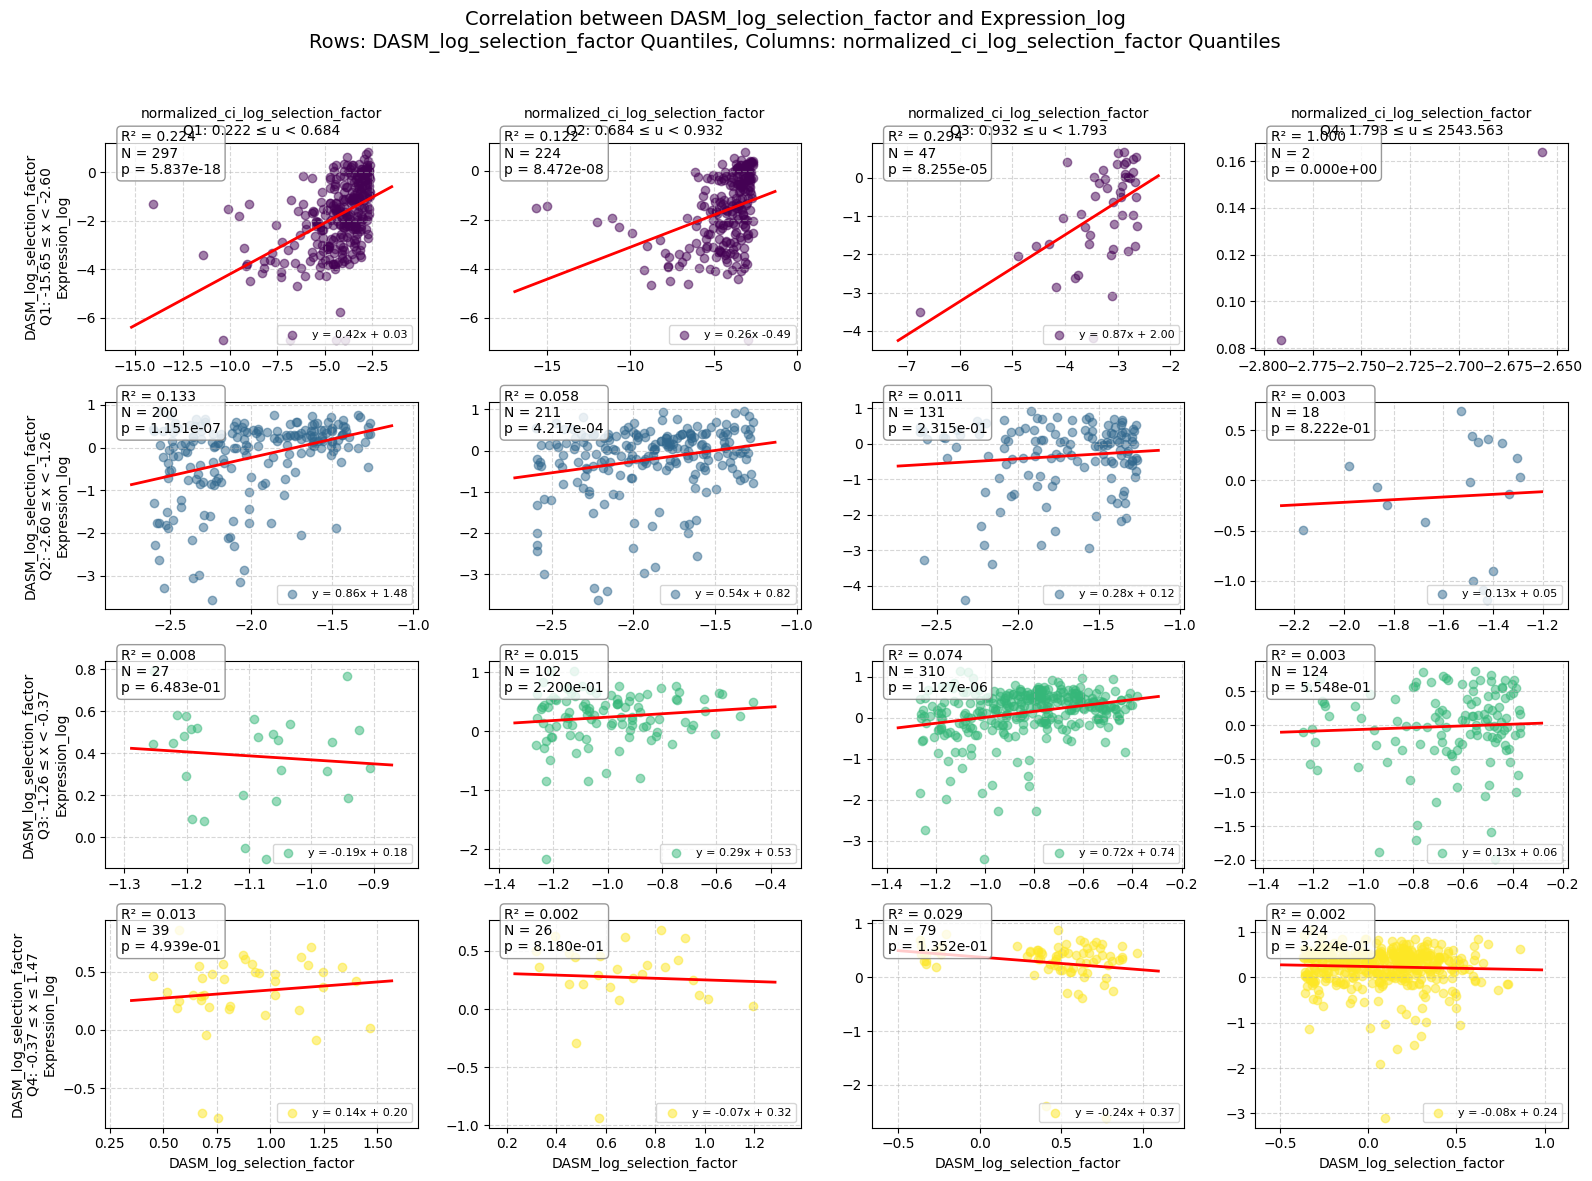


Prediction quantile boundaries:
  Q1: -15.647 to -2.604
  Q2: -2.604 to -1.265
  Q3: -1.265 to -0.370
  Q4: -0.370 to 1.465

Uncertainty quantile boundaries:
  Q1: 0.222 to 0.684
  Q2: 0.684 to 0.932
  Q3: 0.932 to 1.793
  Q4: 1.793 to 2543.563


In [34]:
from scipy import stats

def plot_grid_correlations_quantiles(df, uncertainty_measure, x_col, y_col, 
                                  num_prediction_quantiles=4, num_uncertainty_quantiles=4,
                                  figsize=(20, 12), alpha=0.5, show_grid=True):
    """
    Creates a grid of correlation plots between x_col and y_col.
    - Rows are divided by quantiles of the prediction column (x_col)
    - Columns are divided by quantiles of the specified uncertainty measure
    
    Parameters:
    -----------
    df : pandas DataFrame
        The dataframe containing all the data
    uncertainty_measure : str
        Column name of the uncertainty measure to use for column quantiles
    x_col : str
        Column name for x-axis values in the plots and for row quantiles
    y_col : str
        Column name for y-axis values in the plots
    num_prediction_quantiles : int
        Number of quantiles to divide the prediction values into (rows)
    num_uncertainty_quantiles : int
        Number of quantiles to divide the uncertainty measure into (columns)
    figsize : tuple
        Figure size (width, height) in inches
    alpha : float
        Transparency of scatter points
    show_grid : bool
        Whether to show grid lines in plots
    """
    
    # Create figure with grid based on num_pred_quantiles and num_uncertainty_quantiles
    fig, axes = plt.subplots(num_prediction_quantiles, num_uncertainty_quantiles, 
                             figsize=figsize, squeeze=False)
    
    # Pre-calculate overall limits for consistent axes
    x_min, x_max = df[x_col].min(), df[x_col].max()
    y_min, y_max = df[y_col].min(), df[y_col].max()
    
    # Add some padding to the limits
    x_range = x_max - x_min
    y_range = y_max - y_min
    x_min -= x_range * 0.05
    x_max += x_range * 0.05
    y_min -= y_range * 0.05
    y_max += y_range * 0.05
    
    # Calculate quantile boundaries for predictions (rows)
    prediction_quantile_values = [df[x_col].quantile(i/num_prediction_quantiles) 
                                for i in range(num_prediction_quantiles+1)]
    
    # Calculate quantile boundaries for the uncertainty measure (columns)
    uncertainty_quantile_values = [df[uncertainty_measure].quantile(i/num_uncertainty_quantiles) 
                                  for i in range(num_uncertainty_quantiles+1)]
    
    # Get colors for each row (prediction quantile)
    row_colors = plt.cm.viridis(np.linspace(0, 1, num_prediction_quantiles))
    
    # For each prediction quantile (row)
    for row_idx in range(num_prediction_quantiles):
        # Get prediction quantile boundaries
        pred_lower = prediction_quantile_values[row_idx]
        pred_upper = prediction_quantile_values[row_idx+1]
        
        # Special case for the last quantile to include the maximum value
        if row_idx == num_prediction_quantiles - 1:
            pred_mask = (df[x_col] >= pred_lower) & (df[x_col] <= pred_upper)
            pred_label = f"Q{row_idx+1}: {pred_lower:.2f} ≤ x ≤ {pred_upper:.2f}"
        else:
            pred_mask = (df[x_col] >= pred_lower) & (df[x_col] < pred_upper)
            pred_label = f"Q{row_idx+1}: {pred_lower:.2f} ≤ x < {pred_upper:.2f}"
        
        # For each uncertainty measure quantile (column)
        for col_idx in range(num_uncertainty_quantiles):
            # Get uncertainty quantile boundaries
            unc_lower = uncertainty_quantile_values[col_idx]
            unc_upper = uncertainty_quantile_values[col_idx+1]
            
            # Special case for the last quantile to include the maximum value
            if col_idx == num_uncertainty_quantiles - 1:
                unc_mask = (df[uncertainty_measure] >= unc_lower) & (df[uncertainty_measure] <= unc_upper)
                unc_label = f"Q{col_idx+1}: {unc_lower:.3f} ≤ u ≤ {unc_upper:.3f}"
            else:
                unc_mask = (df[uncertainty_measure] >= unc_lower) & (df[uncertainty_measure] < unc_upper)
                unc_label = f"Q{col_idx+1}: {unc_lower:.3f} ≤ u < {unc_upper:.3f}"
            
            # Combine masks to get data in this specific cell
            combined_mask = pred_mask & unc_mask
            cell_data = df[combined_mask].dropna(subset=[x_col, y_col])
            
            count = len(cell_data)
            
            # Get the current axis
            ax = axes[row_idx, col_idx]
            
            # Calculate statistics for correlation
            if count > 1:  # Need at least 2 points for regression
                slope, intercept, r_value, p_value, std_err = stats.linregress(
                    cell_data[x_col], cell_data[y_col]
                )
                r_squared = r_value**2
                
                # Create scatter plot
                ax.scatter(cell_data[x_col], cell_data[y_col], 
                           alpha=alpha, color=row_colors[row_idx])
                
                # Add regression line for this cell
                if count > 2:  # Only add line if we have enough points for a meaningful regression
                    # Use the actual data range for this cell with some padding
                    cell_x_min, cell_x_max = cell_data[x_col].min(), cell_data[x_col].max()
                    x_padding = (cell_x_max - cell_x_min) * 0.1
                    x_range_line = np.linspace(cell_x_min - x_padding, cell_x_max + x_padding, 100)
                    ax.plot(x_range_line, intercept + slope*x_range_line, 'r-', linewidth=2)
                    
                    # Format the cell equation properly
                    if intercept >= 0:
                        cell_eq = f'y = {slope:.2f}x + {intercept:.2f}'
                    else:
                        cell_eq = f'y = {slope:.2f}x {intercept:.2f}'
                    
                    # Add small legend with just the equation
                    ax.legend([cell_eq], loc='lower right', fontsize=8)
                
                # Add R² annotation
                ax.annotate(
                    f"R² = {r_squared:.3f}\nN = {count}\np = {p_value:.3e}", 
                    xy=(0.05, 0.85), 
                    xycoords='axes fraction',
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
                )
            else:
                ax.text(0.5, 0.5, f"Insufficient data (N={count})", 
                       ha='center', va='center', transform=ax.transAxes)
            
            # Let each plot have its own x-limits for better visualization of each quantile
            if count > 1:
                ax.autoscale(axis='x')
                ax.margins(x=0.1)  # Add 10% padding
            
            # Keep y-limits consistent for easier comparison
            #ax.set_ylim(y_min, y_max)
            
            # Set titles, only on first row/column
            if row_idx == 0:
                ax.set_title(f'{uncertainty_measure}\n{unc_label}', fontsize=10)
            
            if col_idx == 0:
                ax.set_ylabel(f'{x_col}\n{pred_label}\n{y_col}', fontsize=10)
            
            if row_idx == num_prediction_quantiles - 1:
                ax.set_xlabel(x_col, fontsize=10)
            
            # Add grid if requested
            if show_grid:
                ax.grid(True, linestyle='--', alpha=0.5)
    
    # Add a main title
    plt.suptitle(f'Correlation between {x_col} and {y_col}\nRows: {x_col} Quantiles, Columns: {uncertainty_measure} Quantiles', 
                 fontsize=14, y=0.98)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave more room for the suptitle
    plt.show()
    
    # Return a description of the quantile boundaries for reference
    boundaries = {
        f'{x_col}_quantiles': [f"Q{i+1}: {prediction_quantile_values[i]:.3f} to {prediction_quantile_values[i+1]:.3f}" 
                             for i in range(num_prediction_quantiles)],
        f'{uncertainty_measure}_quantiles': [f"Q{i+1}: {uncertainty_quantile_values[i]:.3f} to {uncertainty_quantile_values[i+1]:.3f}" 
                                           for i in range(num_uncertainty_quantiles)]
    }
    
    return boundaries

# Example usage for multiple uncertainty measures
uncertainty_measures = [
    'normalized_ci_log_selection_factor',
]

# Try different numbers of quantiles
for measure in uncertainty_measures:
    print(f"\nAnalyzing: {measure}")
    boundaries = plot_grid_correlations_quantiles(
        df=stats_predict_df, 
        uncertainty_measure=measure,
        x_col='DASM_log_selection_factor',
        y_col='Expression_log',
        num_prediction_quantiles=4,  # 4 rows
        num_uncertainty_quantiles=4,  # 4 columns
        figsize=(16, 12)  # Larger figure size
    )
    
    # Print the quantile boundaries
    print("\nPrediction quantile boundaries:")
    for boundary in boundaries['DASM_log_selection_factor_quantiles']:
        print(f"  {boundary}")
        
    print("\nUncertainty quantile boundaries:")
    for boundary in boundaries[f'{measure}_quantiles']:
        print(f"  {boundary}")


Analyzing grid for: normalized_ci_log_selection_factor


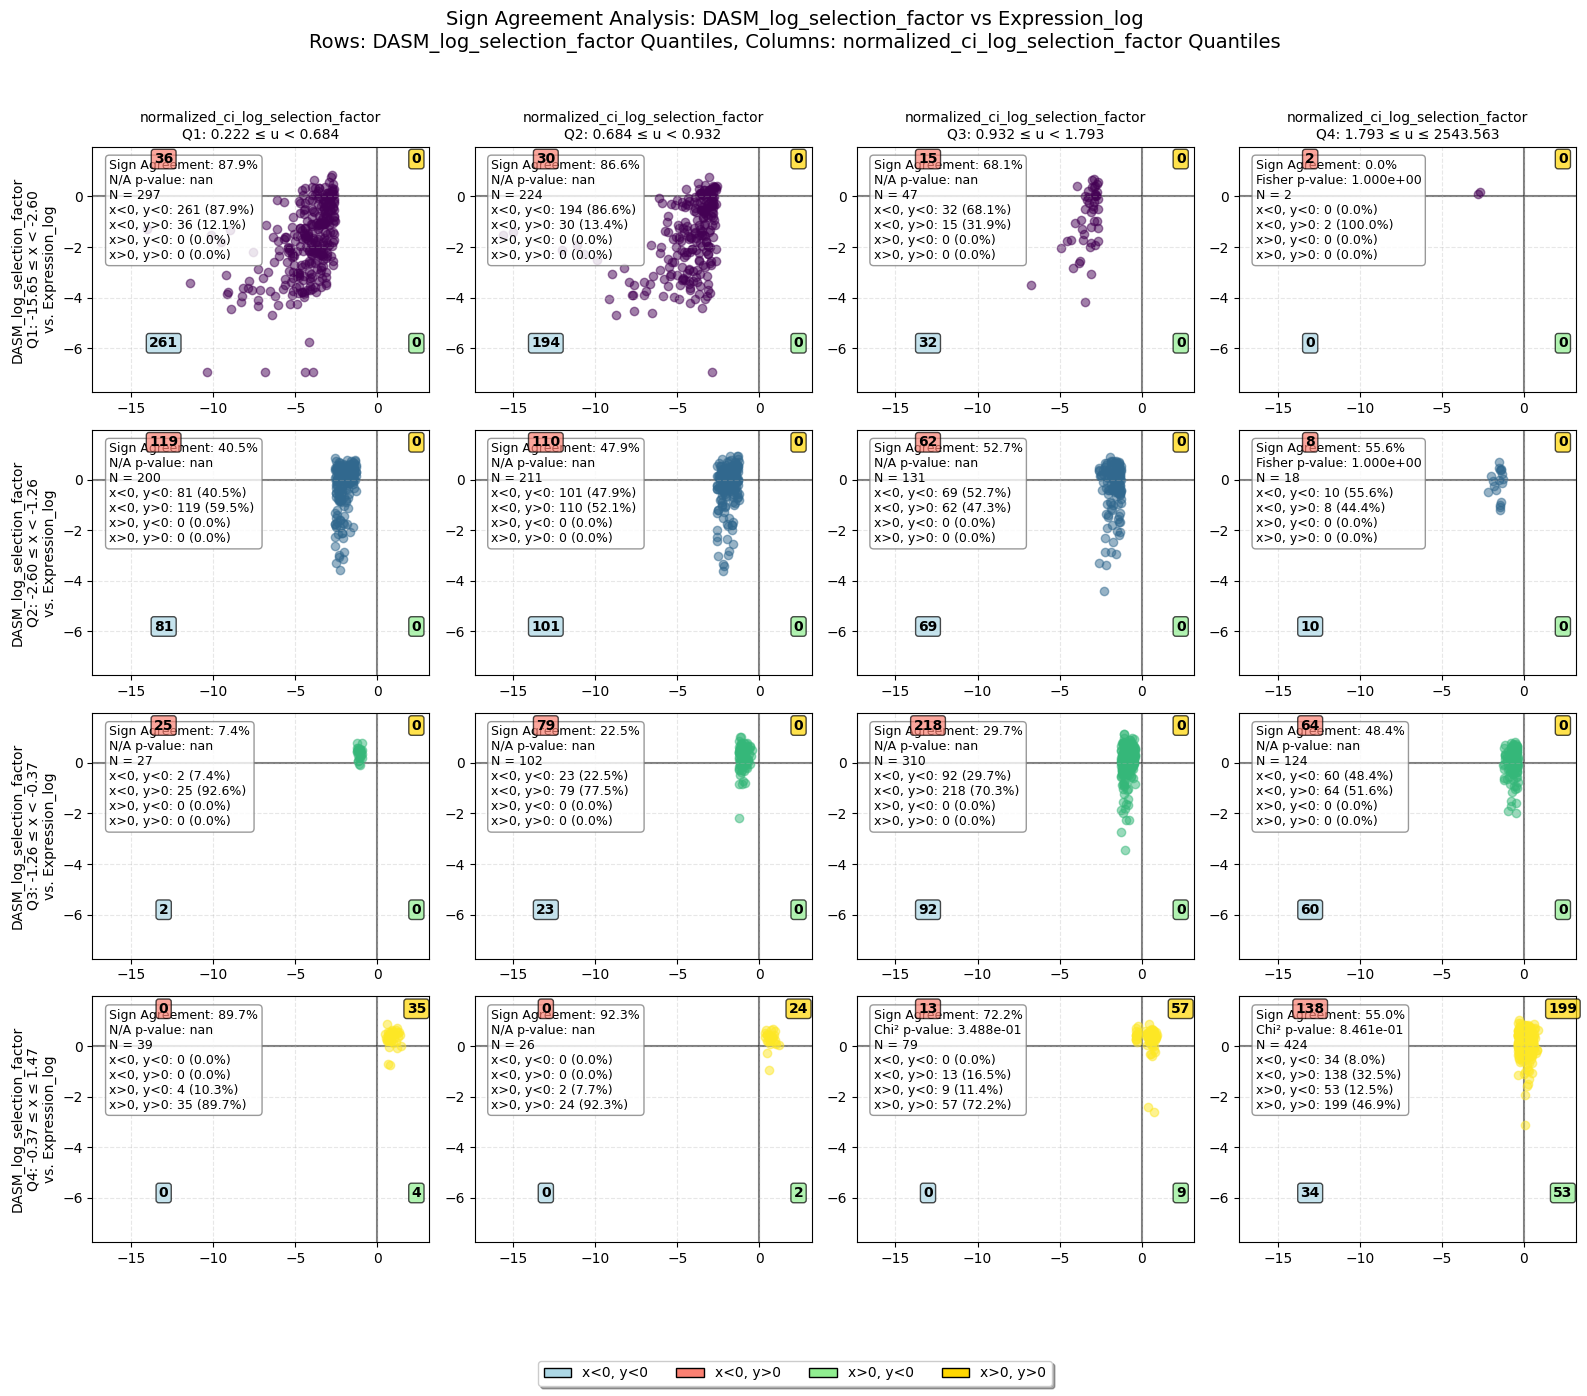


Prediction quantile boundaries:
  Q1: -15.647 to -2.604
  Q2: -2.604 to -1.265
  Q3: -1.265 to -0.370
  Q4: -0.370 to 1.465

Uncertainty quantile boundaries:
  Q1: 0.222 to 0.684
  Q2: 0.684 to 0.932
  Q3: 0.932 to 1.793
  Q4: 1.793 to 2543.563


In [35]:
from scipy import stats


def plot_grid_sign_agreement(df, uncertainty_measure, x_col, y_col, 
                             num_prediction_quantiles=4, num_uncertainty_quantiles=4,
                             figsize=(20, 12), alpha=0.5, show_grid=True):
    """
    Creates a grid of sign agreement analysis between x_col and y_col.
    - Rows are divided by quantiles of the prediction column (x_col)
    - Columns are divided by quantiles of the specified uncertainty measure
    - Instead of R² correlation, calculates sign agreement statistics
    
    Parameters:
    -----------
    df : pandas DataFrame
        The dataframe containing all the data
    uncertainty_measure : str
        Column name of the uncertainty measure to use for column quantiles
    x_col : str
        Column name for prediction values (x-axis) and for row quantiles
    y_col : str
        Column name for expression values (y-axis)
    num_prediction_quantiles : int
        Number of quantiles to divide the prediction values into (rows)
    num_uncertainty_quantiles : int
        Number of quantiles to divide the uncertainty measure into (columns)
    figsize : tuple
        Figure size (width, height) in inches
    alpha : float
        Transparency of scatter points
    show_grid : bool
        Whether to show grid lines in plots
    """
    
    # Create figure with grid based on num_pred_quantiles and num_uncertainty_quantiles
    fig, axes = plt.subplots(num_prediction_quantiles, num_uncertainty_quantiles, 
                             figsize=figsize, squeeze=False)
    
    # Calculate quantile boundaries for predictions (rows)
    prediction_quantile_values = [df[x_col].quantile(i/num_prediction_quantiles) 
                                for i in range(num_prediction_quantiles+1)]
    
    # Calculate quantile boundaries for the uncertainty measure (columns)
    uncertainty_quantile_values = [df[uncertainty_measure].quantile(i/num_uncertainty_quantiles) 
                                  for i in range(num_uncertainty_quantiles+1)]
    
    # Get colors for each row (prediction quantile)
    row_colors = plt.cm.viridis(np.linspace(0, 1, num_prediction_quantiles))
    
    # Get overall min/max for consistent plotting
    overall_x_min = df[x_col].min()
    overall_x_max = df[x_col].max()
    overall_y_min = df[y_col].min()
    overall_y_max = df[y_col].max()
    
    x_range_total = overall_x_max - overall_x_min
    y_range_total = overall_y_max - overall_y_min
    
    extended_x_min = overall_x_min - x_range_total * 0.1
    extended_x_max = overall_x_max + x_range_total * 0.1
    extended_y_min = overall_y_min - y_range_total * 0.1
    extended_y_max = overall_y_max + y_range_total * 0.1
    
    # Store all sign agreement info for return value
    all_sign_info = {}
    
    # For each prediction quantile (row)
    for row_idx in range(num_prediction_quantiles):
        # Get prediction quantile boundaries
        pred_lower = prediction_quantile_values[row_idx]
        pred_upper = prediction_quantile_values[row_idx+1]
        
        # Special case for the last quantile to include the maximum value
        if row_idx == num_prediction_quantiles - 1:
            pred_mask = (df[x_col] >= pred_lower) & (df[x_col] <= pred_upper)
            pred_label = f"Q{row_idx+1}: {pred_lower:.2f} ≤ x ≤ {pred_upper:.2f}"
        else:
            pred_mask = (df[x_col] >= pred_lower) & (df[x_col] < pred_upper)
            pred_label = f"Q{row_idx+1}: {pred_lower:.2f} ≤ x < {pred_upper:.2f}"
        
        # For each uncertainty measure quantile (column)
        for col_idx in range(num_uncertainty_quantiles):
            # Get uncertainty quantile boundaries
            unc_lower = uncertainty_quantile_values[col_idx]
            unc_upper = uncertainty_quantile_values[col_idx+1]
            
            # Special case for the last quantile to include the maximum value
            if col_idx == num_uncertainty_quantiles - 1:
                unc_mask = (df[uncertainty_measure] >= unc_lower) & (df[uncertainty_measure] <= unc_upper)
                unc_label = f"Q{col_idx+1}: {unc_lower:.3f} ≤ u ≤ {unc_upper:.3f}"
            else:
                unc_mask = (df[uncertainty_measure] >= unc_lower) & (df[uncertainty_measure] < unc_upper)
                unc_label = f"Q{col_idx+1}: {unc_lower:.3f} ≤ u < {unc_upper:.3f}"
            
            # Combine masks to get data in this specific cell
            combined_mask = pred_mask & unc_mask
            cell_data = df[combined_mask].dropna(subset=[x_col, y_col])
            
            count = len(cell_data)
            
            # Get the current axis
            ax = axes[row_idx, col_idx]
            
            # Set axes with reference lines at x=0 and y=0
            ax.axhline(y=0, color='black', linestyle='-', alpha=0.5, zorder=0)
            ax.axvline(x=0, color='black', linestyle='-', alpha=0.5, zorder=0)
            
            # Set consistent limits
            ax.set_xlim(extended_x_min, extended_x_max)
            ax.set_ylim(extended_y_min, extended_y_max)
            
            # Calculate sign agreement for cells with sufficient data
            if count > 1:
                # Create scatter plot
                ax.scatter(cell_data[x_col], cell_data[y_col], 
                         alpha=alpha, color=row_colors[row_idx])
                
                # Compute sign agreement
                x_pos = cell_data[x_col] > 0
                y_pos = cell_data[y_col] > 0
                
                # Count points in each quadrant
                top_right = sum(x_pos & y_pos)         # Both positive
                bottom_right = sum(x_pos & ~y_pos)     # x positive, y negative
                top_left = sum(~x_pos & y_pos)         # x negative, y positive
                bottom_left = sum(~x_pos & ~y_pos)     # Both negative
                
                # Create contingency table
                quadrant_counts = np.array([
                    [bottom_left, top_left],     # x<0: [y<0, y>0]
                    [bottom_right, top_right]    # x>0: [y<0, y>0]
                ])
                
                # Calculate sign agreement percentage
                sign_agreement = (top_right + bottom_left) / count * 100
                
                # Calculate chi-square test or Fisher's exact test
                try:
                    if count >= 20:
                        chi2, p_value, dof, expected = stats.chi2_contingency(quadrant_counts)
                        test_type = "Chi²"
                    else:
                        _, p_value = stats.fisher_exact(quadrant_counts)
                        test_type = "Fisher"
                except ValueError:
                    p_value = np.nan
                    test_type = "N/A"
                
                # Format contingency table text
                table_text = (
                    f"Sign Agreement: {sign_agreement:.1f}%\n"
                    f"{test_type} p-value: {p_value:.3e}\n"
                    f"N = {count}\n"
                    f"x<0, y<0: {bottom_left} ({bottom_left/count*100:.1f}%)\n"
                    f"x<0, y>0: {top_left} ({top_left/count*100:.1f}%)\n"
                    f"x>0, y<0: {bottom_right} ({bottom_right/count*100:.1f}%)\n"
                    f"x>0, y>0: {top_right} ({top_right/count*100:.1f}%)"
                )
                
                # Add contingency table as text annotation
                ax.text(0.05, 0.95, table_text,
                      transform=ax.transAxes,
                      verticalalignment='top',
                      bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8),
                      fontsize=9)
                
                # Add quadrant labels with counts
                ax.text(extended_x_max*0.75, extended_y_max*0.75, f"{top_right}",
                        ha='center', va='center', fontweight='bold', fontsize=10,
                        bbox=dict(boxstyle="round,pad=0.2", fc="gold", ec="black", alpha=0.7))
                
                ax.text(extended_x_min*0.75, extended_y_max*0.75, f"{top_left}",
                        ha='center', va='center', fontweight='bold', fontsize=10,
                        bbox=dict(boxstyle="round,pad=0.2", fc="salmon", ec="black", alpha=0.7))
                
                ax.text(extended_x_max*0.75, extended_y_min*0.75, f"{bottom_right}",
                        ha='center', va='center', fontweight='bold', fontsize=10,
                        bbox=dict(boxstyle="round,pad=0.2", fc="lightgreen", ec="black", alpha=0.7))
                
                ax.text(extended_x_min*0.75, extended_y_min*0.75, f"{bottom_left}",
                        ha='center', va='center', fontweight='bold', fontsize=10,
                        bbox=dict(boxstyle="round,pad=0.2", fc="lightblue", ec="black", alpha=0.7))
                
                # Store sign agreement info
                cell_key = f"row{row_idx+1}_col{col_idx+1}"
                all_sign_info[cell_key] = {
                    'row_quantile': row_idx+1,
                    'row_range': (pred_lower, pred_upper),
                    'col_quantile': col_idx+1,
                    'col_range': (unc_lower, unc_upper),
                    'n': count,
                    'sign_agreement_percent': sign_agreement,
                    'p_value': p_value,
                    'test_type': test_type,
                    'quadrants': {
                        'both_positive': top_right,
                        'x_pos_y_neg': bottom_right,
                        'x_neg_y_pos': top_left,
                        'both_negative': bottom_left
                    }
                }
            else:
                ax.text(0.5, 0.5, f"Insufficient data (N={count})", 
                       ha='center', va='center', transform=ax.transAxes)
            
            # Set titles, only on first row/column
            if row_idx == 0:
                ax.set_title(f'{uncertainty_measure}\n{unc_label}', fontsize=10)
            
            if col_idx == 0:
                ax.set_ylabel(f'{x_col}\n{pred_label}\nvs. {y_col}', fontsize=10)
            
            # Add grid if requested
            if show_grid:
                ax.grid(True, linestyle='--', alpha=0.3)
    
    # Create a custom legend for quadrants
    legend_elements = [
        Patch(facecolor='lightblue', edgecolor='black', label='x<0, y<0'),
        Patch(facecolor='salmon', edgecolor='black', label='x<0, y>0'),
        Patch(facecolor='lightgreen', edgecolor='black', label='x>0, y<0'),
        Patch(facecolor='gold', edgecolor='black', label='x>0, y>0')
    ]
    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.02), 
              fancybox=True, shadow=True, ncol=4)
    
    # Add a main title
    plt.suptitle(f'Sign Agreement Analysis: {x_col} vs {y_col}\nRows: {x_col} Quantiles, Columns: {uncertainty_measure} Quantiles', 
                 fontsize=14, y=0.98)
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.96])  # Leave room for title and legend
    plt.subplots_adjust(bottom=0.1)  # Add space for the legend
    plt.show()
    
    # Return a description of the quantile boundaries and sign agreement info
    boundaries = {
        f'{x_col}_quantiles': [f"Q{i+1}: {prediction_quantile_values[i]:.3f} to {prediction_quantile_values[i+1]:.3f}" 
                             for i in range(num_prediction_quantiles)],
        f'{uncertainty_measure}_quantiles': [f"Q{i+1}: {uncertainty_quantile_values[i]:.3f} to {uncertainty_quantile_values[i+1]:.3f}" 
                                           for i in range(num_uncertainty_quantiles)]
    }
    
    return boundaries, all_sign_info

# Example usage for multiple uncertainty measures
uncertainty_measures = [
    'normalized_ci_log_selection_factor',
]

# 1. First create the grid plots for each uncertainty measure
for measure in uncertainty_measures:
    print(f"\nAnalyzing grid for: {measure}")
    boundaries, sign_info = plot_grid_sign_agreement(
        df=stats_predict_df, 
        uncertainty_measure=measure,
        x_col='DASM_log_selection_factor',
        y_col='Expression_log',
        num_prediction_quantiles=4,  # 4 rows
        num_uncertainty_quantiles=4,  # 4 columns
        figsize=(16, 14)
    )
    
    # Print the quantile boundaries
    print("\nPrediction quantile boundaries:")
    for boundary in boundaries['DASM_log_selection_factor_quantiles']:
        print(f"  {boundary}")
        
    print("\nUncertainty quantile boundaries:")
    for boundary in boundaries[f'{measure}_quantiles']:
        print(f"  {boundary}")


### After adding an analysis with the 2x2 table of log selection factor above or below zero and log expression above and below zero, looks like the normalized CI summary statistic is not as good as I had hoped. 
### The normalized CI statistic seems to work well only in cases where the prediction value is farther from 0 and not as well in the middle range. We have a lot of strong negative predictions in the data, which means this is effecting the overall statistics.

### Conclusion: we haven't found a summary statistic that is working well
### Using the distributions (boxplots) to assess the range of error we might be making should still be useful in some cases.